## **Imports**

In [ ]:
!pip install openpyxl
import openpyxl
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
!pip install imbalanced-learn
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
!pip install xgboost
import xgboost as xgbb
from xgboost import XGBClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from sklearn.metrics import average_precision_score, f1_score, balanced_accuracy_score, roc_auc_score, precision_recall_curve, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
!pip install pdfplumber
import pdfplumber

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.1/318.1 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.2/60.2 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 64.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 74.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 90.4 MB/s eta 0:00:00
  Attempting uninstall: cryptography
    Found existing installation: cryptography 3.4.8
    Uninstalling cryptography-3.4.8:
      Successfully uninstalled cryptography-3.4.8


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Associations**

In [ ]:
xls = "/content/drive/MyDrive/virus_hosts_dataset.xlsx"

associations_df = pd.read_excel(xls, sheet_name = 'Associations').drop(columns=["virus", "host",
                                                                                "source", "papers",
                                                                                "fromOtherSources",
                                                                                "sequences"])
associations_df = associations_df[(associations_df["hCat"] == 'mammalia') | (associations_df["hCat"] == 'aves')].rename(
    columns = {"virusEID2ID" : "virusID","HostEID2ID": "hostid" }).drop(columns=["hCat"])

unique_hosts = associations_df["hostid"].unique()
unique_viruses = associations_df["virusID"].unique()
unique_hosts_df = pd.DataFrame(unique_hosts, columns=["hostid"])
unique_viruses_df = pd.DataFrame(unique_viruses, columns=["virusID"])
associations_df["hostid"] = associations_df["hostid"].astype("int32")
associations_df["virusID"] = associations_df["virusID"].astype("int32")
associations_df

,virusID,hostid
4480,3474945,3432625
4481,3474945,3475521
4482,3474945,3516714
4483,3474951,3434261
4484,3474951,3432625
...,...,...
28643,3502576,3563007
28655,29395256,3443341
28656,29395256,3433737
28659,29378397,4010783


# **Hosts**

In [ ]:
diet = pd.read_csv("/content/drive/MyDrive/hosts_diet.csv")
hosts_diet = diet.drop(columns=["host","notes", "class", "Diet-Inv", "Diet-Vend",
                                "Diet-Vect","Diet-Vfish",	"Diet-Vunk", "Diet-Scav",	"Diet-Fruit",
                                "Diet-Nect","Diet-Seed","Diet-PlantO"])
hosts_diet_ = pd.get_dummies(hosts_diet, columns = ["Diet-5Cat"], dtype=int)
hosts_diet_["hostid"] = hosts_diet_["hostid"].astype("int32")
hosts_diet_ = hosts_diet_.astype({col: "Int8" for col in hosts_diet_.columns if col != "hostid"}).drop_duplicates()
hosts_diet_.head(5)

,hostid,Diet-5Cat_FruiNect,Diet-5Cat_Herbivore,Diet-5Cat_Invertebrate,Diet-5Cat_Omnivore,Diet-5Cat_PlantSeed,Diet-5Cat_VertFishScav
0,28874029,0,0,0,0,1,0
1,25938849,1,0,0,0,0,0
2,3930641,0,0,0,0,1,0
3,26210563,0,0,0,0,1,0
4,3580185,0,0,0,0,1,0


In [ ]:
diet_2 = diet.drop(columns=["host", "class", "notes"])
diet_2.head(5)

,hostid,Diet-Inv,Diet-Vend,Diet-Vect,Diet-Vfish,Diet-Vunk,Diet-Scav,Diet-Fruit,Diet-Nect,Diet-Seed,Diet-PlantO,Diet-5Cat
0,28874029,0,0,0,0,0,0,0,0,0,100,PlantSeed
1,25938849,10,0,0,0,0,0,0,90,0,0,FruiNect
2,3930641,10,0,0,0,0,0,10,0,20,60,PlantSeed
3,26210563,20,0,0,0,0,0,10,0,40,30,PlantSeed
4,3580185,0,0,0,0,0,0,0,0,0,100,PlantSeed


In [ ]:
hosts_climat = pd.read_csv("/content/drive/MyDrive/hosts_climat_vars.csv")
hosts_climat = hosts_climat.drop(columns=["host", "hostclass"])

hosts_climat["hostid"] = hosts_climat["hostid"].astype("int32")
hosts_climat = hosts_climat.astype({col: "float16" for col in hosts_climat.columns if col != "hostid"})

hosts_climat

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,hostid,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10
0,3443351,25.609375,179.875000,9.671875,24.656250,26.609375,25.609375,179.875000,9.671875,24.656250,26.609375
1,3443356,1.939453,62.343750,0.997070,1.919922,2.089844,1.939453,62.343750,0.997070,1.919922,2.089844
2,26210429,26.609375,25.609375,179.875000,9.671875,24.656250,26.609375,25.609375,179.875000,9.671875,24.656250
3,3485845,2.089844,1.939453,62.343750,0.997070,1.919922,2.089844,1.939453,62.343750,0.997070,1.919922
4,3730428,24.656250,26.609375,25.609375,179.875000,9.671875,24.656250,26.609375,25.609375,179.875000,9.671875
...,...,...,...,...,...,...,...,...,...,...,...
2663,3453837,2.089844,1.939453,62.343750,0.997070,1.919922,2.089844,1.939453,62.343750,0.997070,1.919922
2664,3466296,24.656250,26.609375,25.609375,179.875000,9.671875,24.656250,26.609375,25.609375,179.875000,9.671875
2665,3611994,1.919922,2.089844,1.939453,62.343750,0.997070,1.919922,2.089844,1.939453,62.343750,0.997070
2666,3631315,9.671875,24.656250,26.609375,25.609375,179.875000,9.671875,24.656250,26.609375,25.609375,179.875000


In [ ]:
pca = PCA(n_components=3)
hosts_climat_ = pca.fit_transform(hosts_climat.drop(columns=["hostid"]))
hosts_climat_df = pd.DataFrame(hosts_climat_, columns=["var1", "var2", "var3"])
hosts_climat_df["hostid"] = hosts_climat["hostid"]
hosts_climat_df["hostid"] = hosts_climat_df["hostid"].astype("int32")
hosts_climat_df = hosts_climat_df.astype({col: "float16" for col in hosts_climat_df.columns if col != "hostid"})
hosts_climat_df

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,var1,var2,var3,hostid
0,88.50000,-121.000000,127.25000,3443351
1,30.65625,-45.312500,52.21875,3443356
2,-142.50000,46.468750,80.31250,26210429
3,-51.46875,19.156250,28.00000,3485845
4,142.12500,47.750000,-77.56250,3730428
...,...,...,...,...
2663,-51.46875,19.156250,28.00000,3453837
2664,142.12500,47.750000,-77.56250,3466296
2665,52.62500,15.585938,-34.90625,3611994
2666,-87.43750,-121.750000,-128.25000,3631315


In [ ]:
hosts_area = pd.read_csv("/content/drive/MyDrive/hosts_area.csv")
hosts_area = hosts_area.drop(columns=["host", "hostclass", "source"])

hosts_area["hostid"] = hosts_area["hostid"].astype("int32")
hosts_area = hosts_area.astype({col: "float32" for col in hosts_area.columns if col != "hostid"})
hosts_area

,hostid,area
0,3696667,4.242292
1,3871654,4.760745
2,3663441,19.402750
3,3914825,91.210571
4,3524422,110.931389
...,...,...
2663,3683411,NaN
2664,29607245,NaN
2665,29599287,NaN
2666,29599303,NaN


In [ ]:
hosts_habitat = pd.read_csv("/content/drive/MyDrive/hosts_habitats.csv")
hosts_habitat = hosts_habitat.drop(columns=["host", "habitat.code", "class", "habitat", "host.iucnid", "habitat.level2", "habitat.suitability"])
hosts_habitat = pd.get_dummies(hosts_habitat, columns = ["habitat.level1"], dtype=int)

hosts_habitat["hostid"] = hosts_habitat["hostid"].astype("int32")
hosts_habitat = hosts_habitat.astype({col: "Int8" for col in hosts_habitat.columns if col != "hostid"}).drop_duplicates()

hosts_habitat

,hostid,habitat.level1_artificial_aquatic,habitat.level1_artificial_terrestrial,habitat.level1_cave_subterranean,habitat.level1_desert,habitat.level1_forest,habitat.level1_grassland,habitat.level1_marine_coastal,habitat.level1_marine_intertidal,habitat.level1_marine_neritic,habitat.level1_marine_oceanic,habitat.level1_other,habitat.level1_rocky_areas,habitat.level1_savanna,habitat.level1_shrubland,habitat.level1_unknown,habitat.level1_wetlands
0,3443351,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,3443351,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,3443351,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,3443351,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5,3443356,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17893,3631315,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17894,3688063,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
17895,3688063,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
17896,3688063,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
hosts_landcover = pd.read_csv("/content/drive/MyDrive/hosts_landcover.csv")

hosts_landcover = hosts_landcover.drop(columns=["host", "hostclass"])
hosts_landcover["hostid"] = hosts_landcover["hostid"].astype("int32")
hosts_landcover = hosts_landcover.astype({col: "float16" for col in hosts_landcover.columns if col != "hostid"})
hosts_landcover

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,hostid,barren _mean,deciduous _mean,evergreen _mean,evergreen_deciduous _mean,flooded_veg _mean,herbaceous_veg _mean,managed_herbs _mean,mixed_trees _mean,shrubs _mean,...,evergreen _sd,evergreen_deciduous _sd,flooded_veg _sd,herbaceous_veg _sd,managed_herbs _sd,mixed_trees _sd,shrubs _sd,snow_ice _sd,urban _sd,water _sd
0,3443351,19.250000,2.009766,8.343750,0.156738,0.239136,13.453125,6.421875,13.117188,33.187500,...,14.429688,0.509766,0.631348,14.695312,13.054688,11.742188,21.390625,4.593750,2.029297,10.554688
1,3443356,25.859375,1.536133,6.496094,0.265137,0.234741,10.906250,4.539062,11.687500,32.593750,...,12.937500,0.880371,0.620117,12.976562,11.164062,11.789062,22.781250,12.000000,1.923828,11.054688
2,26210429,1.798828,1.691406,32.500000,0.972656,0.069702,3.324219,3.126953,38.750000,9.531250,...,15.460938,1.143555,0.150024,4.945312,4.183594,11.023438,5.886719,5.980469,0.419189,12.257812
3,3485845,13.960938,3.097656,0.053955,14.937500,1.892578,8.765625,14.289062,20.625000,14.304688,...,1.289062,22.500000,6.203125,14.312500,27.421875,21.781250,20.109375,17.734375,3.029297,10.796875
4,3730428,0.150024,4.226562,34.468750,0.051941,0.185059,6.257812,27.468750,16.156250,6.882812,...,34.312500,0.408691,0.794434,7.824219,33.281250,19.109375,9.078125,0.003887,7.308594,9.515625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2663,3453837,0.210327,3.580078,10.679688,5.648438,0.403809,1.750977,45.531250,21.953125,6.933594,...,17.953125,7.792969,1.438477,4.570312,31.968750,18.828125,7.511719,0.890625,4.742188,7.695312
2664,3466296,4.628906,3.601562,14.367188,0.390381,0.127319,7.425781,25.750000,20.515625,20.156250,...,25.875000,1.610352,0.725098,12.539062,33.156250,21.656250,21.593750,1.378906,4.492188,9.390625
2665,3611994,1.888672,4.964844,7.187500,7.140625,0.448975,5.617188,39.750000,25.046875,5.300781,...,15.148438,9.648438,1.553711,13.437500,31.921875,21.781250,7.035156,2.083984,3.912109,7.199219
2666,3631315,0.545898,0.418457,56.250000,0.044739,1.304688,11.039062,15.593750,11.453125,1.576172,...,41.062500,0.711914,3.003906,20.046875,20.562500,14.156250,5.320312,0.043854,2.095703,7.238281


In [ ]:
hosts_history_traits = pd.read_csv("/content/drive/MyDrive/hosts_life_history_traits.csv")
hosts_history_traits = hosts_history_traits.drop(columns=["host", "genus", "family", "order", "is.mammal"])

hosts_history_traits["hostid"] = hosts_history_traits["hostid"].astype("int32")
hosts_history_traits["body.mass"] = hosts_history_traits["body.mass"].astype("float32")
hosts_history_traits["gestation.incubation.period"] = hosts_history_traits["gestation.incubation.period"].astype("float32")
hosts_history_traits["clutch.size"] = hosts_history_traits["clutch.size"].astype("float32")
hosts_history_traits = hosts_history_traits.astype({col: "Int8" for col in hosts_history_traits.columns if col not in ["hostid", "body.mass", "gestation.incubation.period", "clutch.size"]})

hosts_history_traits

,hostid,volant,body.mass,gestation.incubation.period,clutch.size,diurnal,nocturnal,cathemeral,crepuscular
0,3443351,0,38.860001,21.90196,4.2725,0,1,0,0
1,3443356,0,24.520000,21.90196,5.3800,0,1,0,0
2,26210429,0,24.700001,21.90196,3.7350,1,1,1,0
3,3485845,1,13.000000,10.50000,5.0000,1,0,0,0
4,3730428,1,10.113750,15.00000,2.1000,1,0,0,0
...,...,...,...,...,...,...,...,...,...
2670,3466296,1,12.537917,11.50000,3.1500,1,0,0,0
2671,3611994,1,11.125000,11.00000,3.7350,1,0,0,0
2672,3631315,0,52.230000,25.66733,4.2525,0,1,0,0
2673,3688063,0,52.230000,25.66733,4.2525,0,1,0,0


In [ ]:
tips = pd.read_csv("/content/drive/MyDrive/Hosts_phylogeny_tips.csv")
aves_es = pd.read_csv("/content/drive/MyDrive/aves_Phylogenetic_diversity_ES.csv")
mammals_es = pd.read_csv("/content/drive/MyDrive/mammals_Phylogenetic_diversity_ES.csv")
mammals_aves = pd.concat([mammals_es, aves_es], ignore_index=True)
phylogeny_tips = pd.merge(mammals_aves, tips, left_on="Species", right_on="tip").drop(columns=["tip", "class", "Species"])
phylogeny_tips = phylogeny_tips.loc[phylogeny_tips["hostid"] !=-1]
phylogeny_tips["hostid"] = phylogeny_tips["hostid"].astype("int32")
phylogeny_tips["w"] = phylogeny_tips["w"].astype("float16")
phylogeny_tips

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,w,hostid
0,36.500000,26725035
1,36.687500,3449353
2,36.812500,26725037
3,69.250000,3433010
4,120.687500,3433004
...,...,...
15962,19.203125,3530088
15963,17.390625,3983258
15965,17.562500,3538449
15966,47.437500,3432995


In [ ]:
livestock = pd.read_csv("/content/drive/MyDrive/hosts_livestock.csv").drop(columns=["host", "hostclass"])
livestock = livestock.astype({col: "float32" for col in livestock.columns if col not in ["hostid"]})
livestock["hostid"] = livestock["hostid"].astype("int32")
livestock


,hostid,chicken,duck,buffalo,cattle,goat,horse,pig,sheep
0,3443351,4.332013e+07,8.130570e+05,1.527286e+05,3.804085e+06,1.390858e+06,5.323486e+05,2.667044e+06,9.252018e+06
1,3443356,4.596487e+07,1.192593e+06,2.360167e+05,4.147689e+06,1.816964e+06,6.091417e+05,2.707134e+06,1.127127e+07
2,26210429,5.668059e+05,2.798455e+04,0.000000e+00,1.237297e+05,2.348505e+03,3.959037e+03,1.888291e+04,9.558398e+04
3,3485845,4.300134e+09,3.674238e+08,1.291448e+06,2.087156e+08,8.420056e+07,1.446510e+07,3.186980e+08,1.775461e+08
4,3730428,7.706588e+07,8.324068e+05,6.718546e+02,1.214309e+07,3.377809e+05,1.124604e+05,1.134728e+06,3.134701e+07
...,...,...,...,...,...,...,...,...,...
2663,3453837,4.567257e+09,6.672024e+08,2.856244e+07,9.245344e+07,1.347804e+08,2.880776e+06,4.250122e+08,2.410572e+07
2664,3466296,1.010938e+08,1.432833e+06,1.271391e+03,3.069195e+07,1.314266e+06,2.597120e+05,2.799503e+06,9.544506e+07
2665,3611994,4.941484e+09,7.254511e+08,2.488915e+07,9.825715e+07,1.547333e+08,4.161280e+06,4.448308e+08,4.903783e+07
2666,3631315,2.043833e+08,1.289812e+06,3.358281e+05,2.937867e+07,1.292903e+06,1.525001e+06,4.979624e+06,1.332928e+06


In [ ]:
merged_hosts = hosts_diet_.merge(hosts_climat_df, on="hostid", how="outer")
merged_hosts_2 = merged_hosts.merge(hosts_area, on="hostid", how="outer")
merged_hosts_3 = merged_hosts_2.merge(hosts_habitat, on="hostid", how="outer")
merged_hosts_4 = merged_hosts_3.merge(hosts_landcover, on="hostid", how="outer")
merged_hosts_5 = merged_hosts_4.merge(hosts_history_traits, on="hostid", how="outer")
merged_hosts_6 = merged_hosts_5.merge(phylogeny_tips, on="hostid", how="outer")
merged_hosts_7 = merged_hosts_6.merge(livestock, on="hostid", how="outer")
pd.set_option('display.max_rows', 100)
hosts_df = merged_hosts_7[merged_hosts_7["hostid"].isin(unique_hosts)].drop_duplicates(subset=["hostid"])
hosts_df.head(20)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,hostid,Diet-5Cat_FruiNect,Diet-5Cat_Herbivore,Diet-5Cat_Invertebrate,Diet-5Cat_Omnivore,Diet-5Cat_PlantSeed,Diet-5Cat_VertFishScav,var1,var2,var3,...,crepuscular,w,chicken,duck,buffalo,cattle,goat,horse,pig,sheep
6,3432186,1,0,0,0,0,0,30.656250,-45.312500,52.218750,...,0,17.609375,3.315766e+06,7.216366e+04,7.677681e+01,2.252040e+05,2.713922e+04,4.477315e+04,3.193926e+05,8.671088e+04
8,3432192,0,0,0,1,0,0,52.625000,15.585938,-34.906250,...,0,34.218750,5.250745e+07,5.228945e+05,4.255763e+03,2.439566e+07,2.924320e+06,2.194941e+05,2.253886e+06,6.401766e+07
12,3432204,0,0,0,1,0,0,-142.500000,46.468750,80.312500,...,0,36.843750,1.372074e+09,6.478090e+06,4.117524e+05,2.255974e+08,9.333922e+06,8.158154e+06,3.917610e+07,2.649484e+07
15,3432212,0,0,0,0,1,0,1.856445,54.437500,4.257812,...,0,71.625000,3.992800e+08,1.180370e+07,1.393242e+01,1.202974e+08,1.253424e+08,2.699158e+06,4.945352e+06,1.318182e+08
19,3432220,0,0,0,0,1,0,88.500000,-121.000000,127.250000,...,0,32.312500,6.858674e+06,1.013064e+06,1.868967e+05,2.168042e+07,2.201253e+06,1.391200e+06,1.565982e+06,9.225362e+06
28,3432272,0,0,0,0,1,0,142.125000,47.750000,-77.562500,...,0,6.667969,2.032921e+09,2.399089e+08,1.180714e+07,4.225834e+07,4.294528e+07,2.438364e+06,2.197202e+08,2.441281e+07
30,3432274,0,0,0,0,1,0,52.625000,15.585938,-34.906250,...,0,6.667969,2.153500e+09,7.743858e+06,9.976362e+05,7.751492e+07,3.848777e+06,9.289824e+06,7.429946e+07,6.497451e+06
32,3432280,0,0,0,1,0,0,-87.437500,-121.750000,-128.250000,...,0,5.847656,3.112623e+08,5.428276e+06,1.270000e+02,6.027837e+07,4.293840e+07,1.090038e+06,4.773515e+06,5.169020e+07
37,3432282,0,0,0,0,1,0,-87.437500,-121.750000,-128.250000,...,0,3.330078,6.394971e+09,6.286301e+08,1.256091e+08,3.936182e+08,3.701785e+08,1.120348e+07,4.534883e+08,2.682090e+08
42,3432284,0,0,0,1,0,0,1.856445,54.437500,4.257812,...,0,0.437256,1.998989e+10,1.323643e+09,1.906967e+08,1.452451e+09,9.532634e+08,6.183584e+07,9.687186e+08,1.120875e+09


# **Viruses**

In [ ]:
viruses_df = pd.read_excel(xls, sheet_name = 'Viruses').drop(columns=['vOrder', 'vFamily', 'vGenus', 'vSpecies',
             'vSpeciesEID2ID', 'virus', 'vNCBITaxID', 'vRecursive', 'vGroup', 'vRank', 'vGroupEID2ID']).rename(
    columns = {"vEId2ID" : "virusID"})
virus_types = pd.get_dummies(viruses_df, columns = ["genome", "baltimore"], dtype=int)
virus_types = virus_types.astype({col: "Int8" for col in virus_types.columns if col not in ["virusID"]}).drop(columns=["genome_DNA"])
virus_types["virusID"] = virus_types["virusID"].astype("int32")
virus_types

,virusID,genome_RNA,baltimore_group I,baltimore_group II,baltimore_group III,baltimore_group IV,baltimore_group V,baltimore_group VI,baltimore_group VII
0,29398396,1,0,0,0,1,0,0,0
1,26615974,1,0,0,0,1,0,0,0
2,29398678,0,1,0,0,0,0,0,0
3,29030186,0,1,0,0,0,0,0,0
4,3436746,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...
27055,3952639,1,0,0,0,1,0,0,0
27056,28993450,1,0,0,0,1,0,0,0
27057,28993454,1,0,0,0,1,0,0,0
27058,3475570,1,0,0,0,1,0,0,0


In [ ]:
virus_traits = pd.read_csv("/content/drive/MyDrive/viruses_traits_processed.csv")
virus_traits = virus_traits.rename(columns = {"virusid" : "virusID"}).drop(columns=["is_rna"])

virus_traits_ = virus_traits.astype({col: "Int8" for col in virus_traits.columns if col != "virusID"})
virus_traits_["virusID"] = virus_traits_["virusID"].astype("int32")

virus_traits_

,virusID,enveloped,spherical,ovoid,icosahedral,brick_shaped,filamentous,pleomorphic,bullet_shaped,rod_shaped,...,surface_spikes_or_peplomers,has_tail,gen_linear,gen_segmented,rep_cytoplasm,rep_nucleus,is_reverse_transcribing,single_stranded,neg_sense,pos_sense
0,3435001,1,1,0,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
1,3498775,1,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,3467181,1,0,0,0,1,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
3,28989602,1,0,0,0,1,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
4,3434653,1,0,0,0,1,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9188,29062726,1,1,0,1,0,0,1,0,0,...,0,0,0,0,1,1,1,0,0,0
9189,27792520,1,1,0,1,0,0,1,0,0,...,0,0,0,0,1,1,1,0,0,0
9190,3452164,1,1,0,1,0,0,1,0,0,...,0,0,0,0,1,1,1,0,0,0
9191,3509107,1,1,0,1,0,0,1,0,0,...,0,0,0,0,1,1,1,0,0,0


In [ ]:
biases = pd.read_csv("/content/drive/MyDrive/viruses_genomic_biases_grouped.csv")
selector = VarianceThreshold(threshold=0.1)
virus_biases = selector.fit_transform(biases)
selected_features = biases.columns[selector.get_support()]
virus_biases = pd.DataFrame(virus_biases, columns=selected_features)
virus_biases["groupid"] = virus_biases["groupid"].astype("int32")
virus_biases["taxid"] = virus_biases["taxid"].astype("int32")
virus_biases = virus_biases.astype({col: "float32" for col in virus_biases.columns if col not in ["groupid", "taxid"]}).drop(columns=["taxid"]).rename(columns={"groupid": "virusID"})
virus_biases


,virusID,GI,length,gc_content,asense_sense_36_prop,asense_sense_300_prop,asense_sense_450_prop,AA_pr_bias,AG_pr_bias,CA_pr_bias,...,CGT_450_bias,CTC_450_bias,CTG_450_bias,GCA_450_bias,GCT_450_bias,GGA_450_bias,GGT_450_bias,GTT_450_bias,TTA_450_bias,TTG_450_bias
0,3434618,3.084434e+07,224499.000000,33.403267,0.954286,1.043956,1.025974,0.926236,0.955479,1.002231,...,0.580645,0.245886,0.288392,0.835497,0.909146,1.454230,0.847820,0.815937,0.971771,0.689918
1,3434620,7.426547e+08,197395.453125,33.072659,1.036325,1.005286,0.969352,0.921558,0.941098,1.010422,...,0.479274,0.230327,0.249378,0.830070,0.888855,1.353445,0.842703,0.760549,0.920659,0.630169
2,3434622,3.295300e+08,192174.000000,33.379829,0.978356,1.003941,0.989462,0.959500,0.947920,0.983311,...,0.484816,0.213631,0.253488,0.759745,0.863801,1.353714,0.807567,0.782403,0.974684,0.674802
3,3434641,9.627521e+06,185578.000000,32.733944,1.001653,1.068493,1.034483,0.922627,0.943318,0.990280,...,0.475386,0.175148,0.228008,0.797565,0.838661,1.320346,0.818182,0.788863,0.955424,0.646943
4,3434643,8.319345e+08,214699.000000,32.331310,0.992733,1.022472,0.973684,0.901997,0.935861,1.037180,...,0.585331,0.199774,0.230926,1.008917,0.875159,1.417888,0.941669,0.864180,1.064560,0.674492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7270,29068388,1.600731e+09,3128.000000,49.072891,3.000000,0.000000,0.000000,1.618759,1.770686,1.172342,...,0.452830,0.904762,0.666667,0.588235,0.941176,0.829268,0.634146,0.588235,0.952381,0.761905
7271,28978098,1.714914e+09,3089.000000,48.111580,2.452381,0.333333,0.000000,1.686789,1.485496,1.230457,...,0.370147,0.683263,0.744269,0.648274,1.107006,0.575676,0.382822,0.608609,0.679658,1.058643
7272,29022272,1.708261e+09,3172.000000,45.192307,3.500000,0.000000,0.000000,1.415532,1.602241,1.266722,...,0.178656,0.575202,0.882850,0.922672,1.026888,0.525604,0.462200,0.834775,0.786617,0.841844
7273,29602986,1.886413e+09,3131.000000,49.356873,2.508658,0.000000,0.000000,1.959499,1.614621,1.394511,...,0.358431,0.740222,0.704233,0.663035,1.020799,0.859575,0.274155,0.489486,0.444003,0.710466


In [ ]:
biases


,groupid,taxid,GI,length,gc_content,orfs_sense_prop_36,orfs_sense_prop_300,orfs_sense_prop_450,asense_sense_36_prop,asense_sense_300_prop,...,amc_charge_neg_450_bias,amc_polar_bias,amc_polar_300_bias,amc_polar_450_bias,amc_hydrogen_donor_bias,amc_hydrogen_donor_300_bias,amc_hydrogen_donor_450_bias,amc_hydrogen_acceptor_bias,amc_hydrogen_acceptor_300_bias,amc_hydrogen_acceptor_450_bias
0,3434618,1.024300e+04,3.084434e+07,224499.00000,33.403267,0.511696,0.489247,0.493590,0.954286,1.043956,...,0.076965,0.514313,0.357423,0.338294,0.420368,0.281002,0.265461,0.409257,0.281475,0.266633
1,3434620,2.093430e+04,7.426546e+08,197395.45614,33.072659,0.491089,0.498729,0.507858,1.036325,1.005286,...,0.069205,0.510655,0.331977,0.307180,0.420215,0.261923,0.241899,0.406168,0.261572,0.242354
2,3434622,2.837373e+05,3.295300e+08,192174.00000,33.379829,0.505480,0.499064,0.502894,0.978356,1.003941,...,0.070221,0.509234,0.340002,0.312094,0.419108,0.268437,0.246130,0.402354,0.266440,0.244592
3,3434641,1.025500e+04,9.627521e+06,185578.00000,32.733945,0.499587,0.483444,0.491525,1.001653,1.068493,...,0.067169,0.511109,0.330484,0.303571,0.422653,0.261804,0.240128,0.405534,0.259425,0.238277
4,3434643,1.025600e+04,8.319344e+08,214699.00000,32.331310,0.501823,0.494444,0.506667,0.992733,1.022472,...,0.075225,0.511995,0.352750,0.333790,0.420298,0.278083,0.262709,0.408647,0.278136,0.263721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7270,29068388,2.557875e+06,1.600731e+09,3128.00000,49.072890,0.250000,1.000000,1.000000,3.000000,0.000000,...,0.028432,0.437043,0.223396,0.223396,0.417547,0.218522,0.218522,0.309504,0.173030,0.173030
7271,28978098,2.596879e+06,1.714914e+09,3089.00000,48.111579,0.292885,0.750000,1.000000,2.452381,0.333333,...,0.032250,0.440282,0.268656,0.225886,0.401673,0.251630,0.214397,0.334122,0.213294,0.178136
7272,29022272,2.596880e+06,1.708261e+09,3172.00000,45.192308,0.223611,1.000000,1.000000,3.500000,0.000000,...,0.032337,0.451960,0.228061,0.228061,0.420541,0.215296,0.215296,0.351126,0.181057,0.181057
7273,29602986,2.760904e+06,1.886413e+09,3131.00000,49.356871,0.285138,1.000000,1.000000,2.508658,0.000000,...,0.026195,0.400134,0.204347,0.204347,0.378402,0.200702,0.200702,0.295704,0.156236,0.156236


In [ ]:
virus_df_merge = virus_types.merge(virus_biases, on="virusID", how="outer")
virus_df = virus_df_merge.merge(virus_traits_, on="virusID", how="outer")
virus_df = virus_df[virus_df["virusID"].isin(unique_viruses)]
virus_df

,virusID,genome_RNA,baltimore_group I,baltimore_group II,baltimore_group III,baltimore_group IV,baltimore_group V,baltimore_group VI,baltimore_group VII,GI,...,surface_spikes_or_peplomers,has_tail,gen_linear,gen_segmented,rep_cytoplasm,rep_nucleus,is_reverse_transcribing,single_stranded,neg_sense,pos_sense
0,3434618,0,1,0,0,0,0,0,0,3.084434e+07,...,0,0,1,0,1,0,0,0,0,0
1,3434620,0,1,0,0,0,0,0,0,7.426547e+08,...,0,0,1,0,1,0,0,0,0,0
2,3434622,0,1,0,0,0,0,0,0,3.295300e+08,...,0,0,1,0,1,0,0,0,0,0
6,3434641,0,1,0,0,0,0,0,0,9.627521e+06,...,0,0,1,0,1,0,0,0,0,0
7,3434643,0,1,0,0,0,0,0,0,8.319345e+08,...,0,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27034,29602986,1,0,0,0,0,0,0,1,1.886413e+09,...,0,0,0,0,1,1,1,0,0,0
27038,29614641,0,1,0,0,0,0,0,0,4.403830e+08,...,0,0,1,0,0,1,0,0,0,0
27041,29614649,1,0,0,0,0,1,0,0,1.669546e+09,...,0,0,1,1,1,0,0,1,1,0
27042,29614651,1,0,0,0,0,1,0,0,1.150147e+09,...,0,0,1,1,1,0,0,1,1,0


# **Viruses+Hosts**

In [ ]:
combinations = pd.merge(unique_viruses_df, unique_hosts_df, how="cross")
combinations = combinations.astype("int32")
combinations

,virusID,hostid
0,3474945,3432625
1,3474945,3475521
2,3474945,3516714
3,3474945,3434261
4,3474945,3434295
...,...,...
8757169,29385279,3863063
8757170,29385279,3611490
8757171,29385279,3451493
8757172,29385279,3499115


In [ ]:
positive = set(zip(associations_df["hostid"], associations_df["virusID"]))
combinations["infects"] = list(zip(combinations["hostid"], combinations["virusID"]))
combinations["infects"] = combinations["infects"].map(lambda x: 1 if x in positive else 0)
combinations["infects"] = combinations["infects"].astype("int8")
combinations

,virusID,hostid,infects
0,3474945,3432625,1
1,3474945,3475521,1
2,3474945,3516714,1
3,3474945,3434261,0
4,3474945,3434295,0
...,...,...,...
8757169,29385279,3863063,0
8757170,29385279,3611490,0
8757171,29385279,3451493,0
8757172,29385279,3499115,0


In [ ]:
xls_file = "/content/drive/MyDrive/Supplementary_Dataset_2.xlsx"

viruses_xls = pd.read_excel(xls_file)
viruses_route = viruses_xls.drop(columns=["virus", "host", "hType", "vGenus", "papers", "evidence"]).rename(
    columns = {"virusEID2ID" : "virusID", "hostEID2ID": "hostid"}).drop_duplicates()
viruses_route = viruses_route[viruses_route["hostid"].isin(unique_hosts)]
viruses_route = viruses_route[viruses_route["virusID"].isin(unique_viruses)]

route_counts = viruses_route["route"].value_counts()
cumulative = route_counts.cumsum()/route_counts.sum()
threshold = cumulative[cumulative <= 0.95].index
viruses_route["route"] = viruses_route["route"].apply(lambda x: x if x in threshold else "other")
route_counts = viruses_route["route"].value_counts()
viruses_route['route_frequency'] = viruses_route['route'].map(route_counts)
viruses_route["virusID"] = viruses_route["virusID"].astype("int32")
viruses_route["hostid"] = viruses_route["hostid"].astype("int32")
viruses_route["route_frequency"] = viruses_route["route_frequency"].astype("int16")
viruses_route = viruses_route.drop(columns=["route"])

viruses_route.head(5)

,virusID,hostid,route_frequency
358,29395308,3433905,5361
359,29395308,3433905,2979
360,29395308,3433905,710
361,29395308,3433905,485
362,29395308,3433905,542


In [ ]:
viruses_head = viruses_xls.drop(columns=["virus", "host", "hType", "vGenus", "papers", "evidence"])
viruses_head.head(5)

,route,virusEID2ID,hostEID2ID
0,passive diffusion,29381513,3431173
1,water-borne,29381513,3431173
2,passive diffusion,29385037,3445908
3,water-borne,29385037,3445908
4,passive diffusion,29602714,3431173


In [ ]:
combinations_route = combinations.merge(viruses_route, on=["hostid", "virusID"], how="left").fillna(0)
combinations_route["route_frequency"] = combinations_route["route_frequency"].astype("int16")
combinations_route

,virusID,hostid,infects,route_frequency
0,3474945,3432625,1,2091
1,3474945,3475521,1,2091
2,3474945,3516714,1,2091
3,3474945,3434261,0,0
4,3474945,3434295,0,0
...,...,...,...,...
8782482,29385279,3863063,0,0
8782483,29385279,3611490,0,0
8782484,29385279,3451493,0,0
8782485,29385279,3499115,0,0


In [ ]:
final_df = combinations_route.merge(virus_df, on="virusID", how="left")
final_df

,virusID,hostid,infects,route_frequency,genome_RNA,baltimore_group I,baltimore_group II,baltimore_group III,baltimore_group IV,baltimore_group V,...,surface_spikes_or_peplomers,has_tail,gen_linear,gen_segmented,rep_cytoplasm,rep_nucleus,is_reverse_transcribing,single_stranded,neg_sense,pos_sense
0,3474945,3432625,1,2091,1,0,0,0,1,0,...,1,0,1,0,1,0,0,1,0,1
1,3474945,3475521,1,2091,1,0,0,0,1,0,...,1,0,1,0,1,0,0,1,0,1
2,3474945,3516714,1,2091,1,0,0,0,1,0,...,1,0,1,0,1,0,0,1,0,1
3,3474945,3434261,0,0,1,0,0,0,1,0,...,1,0,1,0,1,0,0,1,0,1
4,3474945,3434295,0,0,1,0,0,0,1,0,...,1,0,1,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8782482,29385279,3863063,0,0,1,0,0,0,0,1,...,0,0,1,1,1,0,0,1,1,0
8782483,29385279,3611490,0,0,1,0,0,0,0,1,...,0,0,1,1,1,0,0,1,1,0
8782484,29385279,3451493,0,0,1,0,0,0,0,1,...,0,0,1,1,1,0,0,1,1,0
8782485,29385279,3499115,0,0,1,0,0,0,0,1,...,0,0,1,1,1,0,0,1,1,0


In [ ]:
final_df_2 = final_df.merge(hosts_df, on="hostid", how="left")
final_df_2

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,virusID,hostid,infects,route_frequency,genome_RNA,baltimore_group I,baltimore_group II,baltimore_group III,baltimore_group IV,baltimore_group V,...,crepuscular,w,chicken,duck,buffalo,cattle,goat,horse,pig,sheep
0,3474945,3432625,1,2091,1,0,0,0,1,0,...,0,3.494141,2.001361e+10,1.319602e+09,1.897802e+08,1.424880e+09,945232064.0,59703476.00,965140608.0,1.091060e+09
1,3474945,3432625,1,2091,1,0,0,0,1,0,...,0,3.494141,2.001361e+10,1.319602e+09,1.897802e+08,1.424880e+09,945232064.0,59703476.00,965140608.0,1.091060e+09
2,3474945,3475521,1,2091,1,0,0,0,1,0,...,0,6.792969,1.052111e+10,2.442033e+08,1.529547e+08,9.579802e+08,445130144.0,42069304.00,361050176.0,6.948533e+08
3,3474945,3475521,1,2091,1,0,0,0,1,0,...,0,6.792969,1.052111e+10,2.442033e+08,1.529547e+08,9.579802e+08,445130144.0,42069304.00,361050176.0,6.948533e+08
4,3474945,3475521,1,2091,1,0,0,0,1,0,...,0,6.792969,1.052111e+10,2.442033e+08,1.529547e+08,9.579802e+08,445130144.0,42069304.00,361050176.0,6.948533e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27043620,29385279,3494183,1,0,1,0,0,0,0,1,...,0,3.228516,7.392472e+08,3.800785e+07,2.422104e+04,5.159920e+07,5213631.5,2988905.25,64885804.0,2.198324e+07
27043621,29385279,3494183,1,0,1,0,0,0,0,1,...,0,3.228516,7.392472e+08,3.800785e+07,2.422104e+04,5.159920e+07,5213631.5,2988905.25,64885804.0,2.198324e+07
27043622,29385279,3494183,1,0,1,0,0,0,0,1,...,0,3.228516,7.392472e+08,3.800785e+07,2.422104e+04,5.159920e+07,5213631.5,2988905.25,64885804.0,2.198324e+07
27043623,29385279,3494183,1,0,1,0,0,0,0,1,...,0,3.228516,7.392472e+08,3.800785e+07,2.422104e+04,5.159920e+07,5213631.5,2988905.25,64885804.0,2.198324e+07


# **Missing values/Normalisation**

In [ ]:
binary_cols = [col for col in final_df_2.columns if final_df_2[col].dropna().nunique() == 2]

In [ ]:
final_df_2[binary_cols] = final_df_2[binary_cols].apply(lambda col: col.fillna(col.mode()[0]))

In [ ]:
continuous_cols = [col for col in final_df_2.columns if col not in binary_cols and col not in ["virusID", "hostid", "ellipsoidal", "cylindrical", "has_tail"]]

In [ ]:
final_df_2[continuous_cols] = final_df_2[continuous_cols].astype(np.float64)
final_df_2[continuous_cols] = final_df_2[continuous_cols].apply(lambda col: col.fillna(np.nanmean(col)), axis=0)

In [ ]:
# normalisation
for col in continuous_cols:
    final_df_2[col] = (final_df_2[col] - final_df_2[col].mean()) / final_df_2[col].std()

In [ ]:
final_df_2[binary_cols] = final_df_2[binary_cols].astype(np.int8)
final_df_2[continuous_cols] = final_df_2[continuous_cols].astype(np.float32)


In [ ]:
final_df_2 = final_df_2.drop(columns=["has_tail", "ellipsoidal", "cylindrical"]) # all 0s

In [ ]:
final_df_2["human"] = (final_df_2["hostid"] == 3433574).astype("int8")
final_df_2

<ipython-input-34-289b97fa6b43>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final_df_2["human"] = (final_df_2["hostid"] == 3433574).astype("int8")


,virusID,hostid,infects,route_frequency,genome_RNA,baltimore_group I,baltimore_group II,baltimore_group III,baltimore_group IV,baltimore_group V,...,w,chicken,duck,buffalo,cattle,goat,horse,pig,sheep,human
0,3474945,3432625,1,7.472338,1,0,0,0,1,0,...,-0.615548,5.622133,4.146256,3.920463,5.867961,5.177699,5.864378,4.738398,5.621775,0
1,3474945,3432625,1,7.472338,1,0,0,0,1,0,...,-0.615548,5.622133,4.146256,3.920463,5.867961,5.177699,5.864378,4.738398,5.621775,0
2,3474945,3475521,1,7.472338,1,0,0,0,1,0,...,-0.122154,2.678950,0.388602,3.078403,3.748463,2.165851,3.957299,1.436743,3.393244,0
3,3474945,3475521,1,7.472338,1,0,0,0,1,0,...,-0.122154,2.678950,0.388602,3.078403,3.748463,2.165851,3.957299,1.436743,3.393244,0
4,3474945,3475521,1,7.472338,1,0,0,0,1,0,...,-0.122154,2.678950,0.388602,3.078403,3.748463,2.165851,3.957299,1.436743,3.393244,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27043620,29385279,3494183,1,-0.071308,1,0,0,0,0,1,...,-0.655276,-0.353953,-0.331886,-0.418531,-0.366066,-0.483533,-0.269119,-0.181943,-0.391431,0
27043621,29385279,3494183,1,-0.071308,1,0,0,0,0,1,...,-0.655276,-0.353953,-0.331886,-0.418531,-0.366066,-0.483533,-0.269119,-0.181943,-0.391431,0
27043622,29385279,3494183,1,-0.071308,1,0,0,0,0,1,...,-0.655276,-0.353953,-0.331886,-0.418531,-0.366066,-0.483533,-0.269119,-0.181943,-0.391431,0
27043623,29385279,3494183,1,-0.071308,1,0,0,0,0,1,...,-0.655276,-0.353953,-0.331886,-0.418531,-0.366066,-0.483533,-0.269119,-0.181943,-0.391431,0


# **Predict which viral features influence infectivity**

In [ ]:
# dataset of human hosts
homo_sapiens_df = final_df_2[final_df_2["human"] == 1]
homo_sapiens_df = homo_sapiens_df.drop_duplicates(subset=["virusID"])
homo_sapiens_df

,virusID,hostid,infects,route_frequency,genome_RNA,baltimore_group I,baltimore_group II,baltimore_group III,baltimore_group IV,baltimore_group V,...,w,chicken,duck,buffalo,cattle,goat,horse,pig,sheep,human
26,3474945,3433574,0,-0.071308,1,0,0,0,1,0,...,-0.51126,5.615626,4.129532,3.927986,5.900473,5.166206,5.904549,4.756086,5.516686,1
7018,3474951,3433574,0,-0.071308,1,0,0,0,1,0,...,-0.51126,5.615626,4.129532,3.927986,5.900473,5.166206,5.904549,4.756086,5.516686,1
14014,29395098,3433574,1,7.472338,1,0,0,0,0,1,...,-0.51126,5.615626,4.129532,3.927986,5.900473,5.166206,5.904549,4.756086,5.516686,1
21022,3435176,3433574,0,-0.071308,0,1,0,0,0,0,...,-0.51126,5.615626,4.129532,3.927986,5.900473,5.166206,5.904549,4.756086,5.516686,1
28079,3496723,3433574,1,8.850469,1,0,0,0,1,0,...,-0.51126,5.615626,4.129532,3.927986,5.900473,5.166206,5.904549,4.756086,5.516686,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27008691,22680739,3433574,0,-0.071308,1,0,0,0,0,1,...,-0.51126,5.615626,4.129532,3.927986,5.900473,5.166206,5.904549,4.756086,5.516686,1
27015683,3502576,3433574,0,-0.071308,1,0,0,0,1,0,...,-0.51126,5.615626,4.129532,3.927986,5.900473,5.166206,5.904549,4.756086,5.516686,1
27022675,29395256,3433574,0,-0.071308,0,1,0,0,0,0,...,-0.51126,5.615626,4.129532,3.927986,5.900473,5.166206,5.904549,4.756086,5.516686,1
27029667,29378397,3433574,0,-0.071308,1,0,0,0,1,0,...,-0.51126,5.615626,4.129532,3.927986,5.900473,5.166206,5.904549,4.756086,5.516686,1


In [ ]:
# split samples with viral features into train/test
viral_features = [col for col in homo_sapiens_df.columns if (col in virus_df.columns and col not in ["virusID", "human"])]
X_virus = homo_sapiens_df[viral_features]
y_virus = homo_sapiens_df["infects"]
X_train_virus, X_test_virus, y_train_virus, y_test_virus = train_test_split(X_virus, y_virus, test_size=0.2, random_state=1, stratify=y_virus)

In [ ]:
# undersample
rus = RandomUnderSampler(random_state=1)
X_train_under, y_train_under = rus.fit_resample(X_train_virus, y_train_virus)

In [ ]:
# oversample
ros = RandomOverSampler(random_state=1)
X_train_over, y_train_over = ros.fit_resample(X_train_virus, y_train_virus)

In [ ]:
# smote
smote = SMOTE(random_state=1)
X_train_smote, y_train_smote = smote.fit_resample(X_train_virus, y_train_virus)

### **Logistic Regression**

In [ ]:
# original
lr_virus = LogisticRegression(max_iter=300, class_weight="balanced")
lr_virus.fit(X_train_virus, y_train_virus)

y_pred_virus_1 = lr_virus.predict(X_test_virus)
y_prob_virus_1 = lr_virus.predict_proba(X_test_virus)[:, 1]

roc_auc_1 = roc_auc_score(y_test_virus, y_prob_virus_1)
pr_auc_1 = average_precision_score(y_test_virus, y_prob_virus_1)
f1_1 = f1_score(y_test_virus, y_pred_virus_1)
balanced_acc_1 = balanced_accuracy_score(y_test_virus, y_pred_virus_1)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
scores = cross_val_score(lr_virus, X_virus, y_virus, cv=skf, scoring='average_precision')
scores = scores.round(2)

print("Cross-validated PR-AUC scores: ", scores)
print(f"Mean cross-validated PR-AUC: {scores.mean():.2f}")
print()
print(f"PR-AUC Score: {pr_auc_1:.2f}")
print(f"ROC-AUC Score: {roc_auc_1:.2f}")
print(f"F1 Score: {f1_1:.2f}")
print(f"Balanced Accuracy: {balanced_acc_1:.2f}")
print("\nClassification Report:\n", classification_report(y_test_virus, y_pred_virus_1))

Cross-validated PR-AUC scores:  [0.7  0.75 0.72 0.74 0.76]
Mean cross-validated PR-AUC: 0.73

PR-AUC Score: 0.70
ROC-AUC Score: 0.79
F1 Score: 0.65
Balanced Accuracy: 0.73

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.75      0.78       493
           1       0.61      0.70      0.65       278

    accuracy                           0.73       771
   macro avg       0.71      0.73      0.72       771
weighted avg       0.74      0.73      0.74       771



In [ ]:
# undersampled
lr_virus_d = LogisticRegression(max_iter=300)
lr_virus_d.fit(X_train_under, y_train_under)
y_pred_virus_2 = lr_virus_d.predict(X_test_virus)
y_prob_virus_2 = lr_virus_d.predict_proba(X_test_virus)[:, 1]

roc_auc_2 = roc_auc_score(y_test_virus, y_prob_virus_2)
pr_auc_2= average_precision_score(y_test_virus, y_prob_virus_2)
f1_2 = f1_score(y_test_virus, y_pred_virus_2)
balanced_acc_2 = balanced_accuracy_score(y_test_virus, y_pred_virus_2)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
scores = cross_val_score(lr_virus_d, X_virus, y_virus, cv=skf, scoring='average_precision').round(2)

print("Cross-validated PR-AUC scores: ", scores)
print(f"Mean cross-validated PR-AUC: {scores.mean():.2f}")
print()
print(f"PR-AUC Score: {pr_auc_2:.2f}")
print(f"ROC-AUC Score: {roc_auc_2:.2f}")
print(f"F1 Score: {f1_2:.2f}")
print(f"Balanced Accuracy: {balanced_acc_2:.2f}")
print("\nClassification Report:\n", classification_report(y_test_virus, y_pred_virus_2))

Cross-validated PR-AUC scores:  [0.71 0.76 0.73 0.75 0.77]
Mean cross-validated PR-AUC: 0.74

PR-AUC Score: 0.70
ROC-AUC Score: 0.79
F1 Score: 0.64
Balanced Accuracy: 0.71

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.75      0.78       493
           1       0.60      0.68      0.64       278

    accuracy                           0.72       771
   macro avg       0.71      0.71      0.71       771
weighted avg       0.73      0.72      0.73       771



In [ ]:
# oversampled
lr_virus_o = LogisticRegression(max_iter=300)
lr_virus_o.fit(X_train_over, y_train_over)
y_pred_virus_3 = lr_virus_o.predict(X_test_virus)
y_prob_virus_3 = lr_virus_o.predict_proba(X_test_virus)[:, 1]

roc_auc_3 = roc_auc_score(y_test_virus, y_prob_virus_3)
pr_auc_3 = average_precision_score(y_test_virus, y_prob_virus_3)
f1_3 = f1_score(y_test_virus, y_pred_virus_3)
balanced_acc_3 = balanced_accuracy_score(y_test_virus, y_pred_virus_3)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
scores = cross_val_score(lr_virus_o, X_virus, y_virus, cv=skf, scoring='average_precision').round(2)

print("Cross-validated PR-AUC scores: ", scores)
print(f"Mean cross-validated PR-AUC: {scores.mean():.2f}")
print()
print(f"PR-AUC Score: {pr_auc_3:.2f}")
print(f"ROC-AUC Score: {roc_auc_3:.2f}")
print(f"F1 Score: {f1_3:.2f}")
print(f"Balanced Accuracy: {balanced_acc_3:.2f}")
print("\nClassification Report:\n", classification_report(y_test_virus, y_pred_virus_3))

Cross-validated PR-AUC scores:  [0.71 0.76 0.73 0.75 0.77]
Mean cross-validated PR-AUC: 0.74

PR-AUC Score: 0.69
ROC-AUC Score: 0.79
F1 Score: 0.64
Balanced Accuracy: 0.71

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.75      0.77       493
           1       0.60      0.68      0.64       278

    accuracy                           0.72       771
   macro avg       0.70      0.71      0.71       771
weighted avg       0.73      0.72      0.73       771



In [ ]:
# smote
lr_virus_sm = LogisticRegression(max_iter=300)
lr_virus_sm.fit(X_train_smote, y_train_smote)
y_pred_virus_4 = lr_virus_sm.predict(X_test_virus)
y_prob_virus_4 = lr_virus_sm.predict_proba(X_test_virus)[:, 1]

roc_auc_4 = roc_auc_score(y_test_virus, y_prob_virus_4)
pr_auc_4 = average_precision_score(y_test_virus, y_prob_virus_4)
f1_4 = f1_score(y_test_virus, y_pred_virus_4)
balanced_acc_4 = balanced_accuracy_score(y_test_virus, y_pred_virus_4)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
scores = cross_val_score(lr_virus_sm, X_virus, y_virus, cv=skf, scoring='average_precision').round(2)

print("Cross-validated PR-AUC scores: ", scores)
print(f"Mean cross-validated PR-AUC: {scores.mean():.2f}")
print()
print(f"PR-AUC Score: {pr_auc_4:.2f}")
print(f"ROC-AUC Score: {roc_auc_4:.2f}")
print(f"F1 Score: {f1_4:.2f}")
print(f"Balanced Accuracy: {balanced_acc_4:.2f}")
print("\nClassification Report:\n", classification_report(y_test_virus, y_pred_virus_4))

Cross-validated PR-AUC scores:  [0.71 0.76 0.73 0.75 0.77]
Mean cross-validated PR-AUC: 0.74

PR-AUC Score: 0.70
ROC-AUC Score: 0.79
F1 Score: 0.65
Balanced Accuracy: 0.73

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.76      0.78       493
           1       0.62      0.69      0.65       278

    accuracy                           0.73       771
   macro avg       0.72      0.73      0.72       771
weighted avg       0.74      0.73      0.74       771



### **Random Forest**

In [ ]:
#original
rf_virus = RandomForestClassifier(class_weight='balanced', random_state=1)
rf_virus.fit(X_train_virus, y_train_virus)
y_pred_virus_5 = rf_virus.predict(X_test_virus)
y_prob_virus_5 = rf_virus.predict_proba(X_test_virus)[:, 1]

roc_auc_5 = roc_auc_score(y_test_virus, y_prob_virus_5)
pr_auc_5 = average_precision_score(y_test_virus, y_prob_virus_5)
f1_5 = f1_score(y_test_virus, y_pred_virus_5)
balanced_acc_5 = balanced_accuracy_score(y_test_virus, y_pred_virus_5)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
scores = cross_val_score(rf_virus, X_virus, y_virus, cv=skf, scoring='average_precision')

print("Cross-validated PR-AUC scores: ", scores)
print(f"Mean cross-validated PR-AUC: {scores.mean():.2f}")
print()
print(f"PR-AUC Score: {pr_auc_5:.2f}")
print(f"ROC-AUC Score: {roc_auc_5:.2f}")
print(f"F1 Score: {f1_5:.2f}")
print(f"Balanced Accuracy: {balanced_acc_5:.2f}")
print("\nClassification Report:\n", classification_report(y_test_virus, y_pred_virus_5))


Cross-validated PR-AUC scores:  [0.88687763 0.90643078 0.89636502 0.88152998 0.91500084]
Mean cross-validated PR-AUC: 0.90

PR-AUC Score: 0.89
ROC-AUC Score: 0.91
F1 Score: 0.77
Balanced Accuracy: 0.81

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.95      0.89       493
           1       0.88      0.68      0.77       278

    accuracy                           0.85       771
   macro avg       0.86      0.81      0.83       771
weighted avg       0.86      0.85      0.85       771



In [ ]:
#undersampled
rf_virus_d = RandomForestClassifier(random_state=1)
rf_virus_d.fit(X_train_under, y_train_under)
y_pred_virus_6 = rf_virus_d.predict(X_test_virus)
y_prob_virus_6 = rf_virus_d.predict_proba(X_test_virus)[:, 1]

roc_auc_6 = roc_auc_score(y_test_virus, y_prob_virus_6)
pr_auc_6 = average_precision_score(y_test_virus, y_prob_virus_6)
f1_6 = f1_score(y_test_virus, y_pred_virus_6)
balanced_acc_6 = balanced_accuracy_score(y_test_virus, y_pred_virus_6)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
scores = cross_val_score(rf_virus_d, X_virus, y_virus, cv=skf, scoring='average_precision')

print("Cross-validated PR-AUC scores: ", scores)
print(f"Mean cross-validated PR-AUC: {scores.mean():.2f}")
print()
print(f"PR-AUC Score: {pr_auc_6:.2f}")
print(f"ROC-AUC Score: {roc_auc_6:.2f}")
print(f"F1 Score: {f1_6:.2f}")
print(f"Balanced Accuracy: {balanced_acc_6:.2f}")
print("\nClassification Report:\n", classification_report(y_test_virus, y_pred_virus_6))

Cross-validated PR-AUC scores:  [0.87724588 0.89551562 0.89121743 0.87684523 0.91716338]
Mean cross-validated PR-AUC: 0.89

PR-AUC Score: 0.89
ROC-AUC Score: 0.91
F1 Score: 0.78
Balanced Accuracy: 0.83

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.87      0.88       493
           1       0.78      0.79      0.78       278

    accuracy                           0.84       771
   macro avg       0.83      0.83      0.83       771
weighted avg       0.84      0.84      0.84       771



In [ ]:
#oversampled
rf_virus_o = RandomForestClassifier(random_state=1)
rf_virus_o.fit(X_train_over, y_train_over)
y_pred_virus_7 = rf_virus_o.predict(X_test_virus)
y_prob_virus_7 = rf_virus_o.predict_proba(X_test_virus)[:, 1]

roc_auc_7 = roc_auc_score(y_test_virus, y_prob_virus_7)
pr_auc_7 = average_precision_score(y_test_virus, y_prob_virus_7)
f1_7 = f1_score(y_test_virus, y_pred_virus_7)
balanced_acc_7 = balanced_accuracy_score(y_test_virus, y_pred_virus_7)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
scores = cross_val_score(rf_virus_o, X_virus, y_virus, cv=skf, scoring='average_precision')

print("Cross-validated PR-AUC scores: ", scores)
print(f"Mean cross-validated PR-AUC: {scores.mean():.2f}")
print()
print(f"PR-AUC Score: {pr_auc_7:.2f}")
print(f"ROC-AUC Score: {roc_auc_7:.2f}")
print(f"F1 Score: {f1_7:.2f}")
print(f"Balanced Accuracy: {balanced_acc_7:.2f}")
print("\nClassification Report:\n", classification_report(y_test_virus, y_pred_virus_7))


Cross-validated PR-AUC scores:  [0.87724588 0.89551562 0.89121743 0.87684523 0.91716338]
Mean cross-validated PR-AUC: 0.89

PR-AUC Score: 0.89
ROC-AUC Score: 0.91
F1 Score: 0.80
Balanced Accuracy: 0.84

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.94      0.90       493
           1       0.88      0.73      0.80       278

    accuracy                           0.87       771
   macro avg       0.87      0.84      0.85       771
weighted avg       0.87      0.87      0.86       771



In [ ]:
#smote
rf_virus_sm = RandomForestClassifier(random_state=1)
rf_virus_sm.fit(X_train_smote, y_train_smote)
y_pred_virus_8 = rf_virus_sm.predict(X_test_virus)
y_prob_virus_8 = rf_virus_sm.predict_proba(X_test_virus)[:, 1]

roc_auc_8 = roc_auc_score(y_test_virus, y_prob_virus_8)
pr_auc_8 = average_precision_score(y_test_virus, y_prob_virus_8)
f1_8 = f1_score(y_test_virus, y_pred_virus_8)
balanced_acc_8 = balanced_accuracy_score(y_test_virus, y_pred_virus_8)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
scores = cross_val_score(rf_virus_sm, X_virus, y_virus, cv=skf, scoring='average_precision')

print("Cross-validated PR-AUC scores: ", scores)
print(f"Mean cross-validated PR-AUC: {scores.mean():.2f}")
print()
print(f"PR-AUC Score: {pr_auc_8:.2f}")
print(f"ROC-AUC Score: {roc_auc_8:.2f}")
print(f"F1 Score: {f1_8:.2f}")
print(f"Balanced Accuracy: {balanced_acc_8:.2f}")
print("\nClassification Report:\n", classification_report(y_test_virus, y_pred_virus_8))

Cross-validated PR-AUC scores:  [0.87724588 0.89551562 0.89121743 0.87684523 0.91716338]
Mean cross-validated PR-AUC: 0.89

PR-AUC Score: 0.89
ROC-AUC Score: 0.92
F1 Score: 0.80
Balanced Accuracy: 0.84

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.93      0.90       493
           1       0.86      0.75      0.80       278

    accuracy                           0.87       771
   macro avg       0.86      0.84      0.85       771
weighted avg       0.86      0.87      0.86       771



### **XGB**

In [ ]:
#original
xgb = XGBClassifier()
xgb_virus = xgb.fit(X_train_virus, y_train_virus)
y_pred_virus_9 = xgb_virus.predict(X_test_virus)
y_prob_virus_9 = xgb_virus.predict_proba(X_test_virus)[:, 1]

roc_auc_9 = roc_auc_score(y_test_virus, y_prob_virus_9)
pr_auc_9 = average_precision_score(y_test_virus, y_prob_virus_9)
f1_9 = f1_score(y_test_virus, y_pred_virus_9)
balanced_acc_9 = balanced_accuracy_score(y_test_virus, y_pred_virus_9)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
scores = cross_val_score(xgb_virus, X_virus, y_virus, cv=skf, scoring='average_precision')

print("Cross-validated PR-AUC scores: ", scores)
print(f"Mean cross-validated PR-AUC: {scores.mean():.2f}")
print()
print(f"PR-AUC Score: {pr_auc_9:.2f}")
print(f"ROC-AUC Score: {roc_auc_9:.2f}")
print(f"F1 Score: {f1_9:.2f}")
print(f"Balanced Accuracy: {balanced_acc_9:.2f}")
print("\nClassification Report:\n", classification_report(y_test_virus, y_pred_virus_9))

Cross-validated PR-AUC scores:  [0.88222823 0.90342605 0.89367123 0.88246621 0.92020933]
Mean cross-validated PR-AUC: 0.90

PR-AUC Score: 0.88
ROC-AUC Score: 0.90
F1 Score: 0.78
Balanced Accuracy: 0.83

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.92      0.89       493
           1       0.83      0.73      0.78       278

    accuracy                           0.85       771
   macro avg       0.85      0.83      0.83       771
weighted avg       0.85      0.85      0.85       771



In [ ]:
#undersampled
xgb_virus_d = xgb.fit(X_train_under, y_train_under)
y_pred_virus_10 = xgb_virus_d.predict(X_test_virus)
y_prob_virus_10 = xgb_virus_d.predict_proba(X_test_virus)[:, 1]

roc_auc_10 = roc_auc_score(y_test_virus, y_prob_virus_10)
pr_auc_10 = average_precision_score(y_test_virus, y_prob_virus_10)
f1_10 = f1_score(y_test_virus, y_pred_virus_10)
balanced_acc_10 = balanced_accuracy_score(y_test_virus, y_pred_virus_10)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
scores = cross_val_score(xgb_virus_d, X_virus, y_virus, cv=skf, scoring='average_precision').round(2)

print("Cross-validated PR-AUC scores: ", scores)
print(f"Mean cross-validated PR-AUC: {scores.mean():.2f}")
print()
print(f"PR-AUC Score: {pr_auc_10:.2f}")
print(f"ROC-AUC Score: {roc_auc_10:.2f}")
print(f"F1 Score: {f1_10:.2f}")
print(f"Balanced Accuracy: {balanced_acc_10:.2f}")
print("\nClassification Report:\n", classification_report(y_test_virus, y_pred_virus_10))

Cross-validated PR-AUC scores:  [0.88 0.9  0.89 0.88 0.92]
Mean cross-validated PR-AUC: 0.89

PR-AUC Score: 0.89
ROC-AUC Score: 0.91
F1 Score: 0.80
Balanced Accuracy: 0.85

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.87      0.88       493
           1       0.78      0.82      0.80       278

    accuracy                           0.85       771
   macro avg       0.84      0.85      0.84       771
weighted avg       0.86      0.85      0.85       771



In [ ]:
#oversampled
xgb_virus_o = xgb.fit(X_train_over, y_train_over)
y_pred_virus_11 = xgb_virus_o.predict(X_test_virus)
y_prob_virus_11 = xgb_virus_o.predict_proba(X_test_virus)[:, 1]

roc_auc_11 = roc_auc_score(y_test_virus, y_prob_virus_11)
pr_auc_11 = average_precision_score(y_test_virus, y_prob_virus_11)
f1_11 = f1_score(y_test_virus, y_pred_virus_11)
balanced_acc_11 = balanced_accuracy_score(y_test_virus, y_pred_virus_11)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
scores = cross_val_score(xgb_virus_o, X_virus, y_virus, cv=skf, scoring='average_precision').round(2)

print("Cross-validated PR-AUC scores: ", scores)
print(f"Mean cross-validated PR-AUC: {scores.mean():.2f}")
print()
print(f"PR-AUC Score: {pr_auc_11:.2f}")
print(f"ROC-AUC Score: {roc_auc_11:.2f}")
print(f"F1 Score: {f1_11:.2f}")
print(f"Balanced Accuracy: {balanced_acc_11:.2f}")
print("\nClassification Report:\n", classification_report(y_test_virus, y_pred_virus_11))

Cross-validated PR-AUC scores:  [0.88 0.9  0.89 0.88 0.92]
Mean cross-validated PR-AUC: 0.89

PR-AUC Score: 0.88
ROC-AUC Score: 0.90
F1 Score: 0.78
Balanced Accuracy: 0.82

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.92      0.89       493
           1       0.84      0.73      0.78       278

    accuracy                           0.85       771
   macro avg       0.85      0.82      0.83       771
weighted avg       0.85      0.85      0.85       771



In [ ]:
#smote
xgb_virus_sm = xgb.fit(X_train_smote, y_train_smote)
y_pred_virus_12 = xgb_virus_sm.predict(X_test_virus)
y_prob_virus_12 = xgb_virus_sm.predict_proba(X_test_virus)[:, 1]

roc_auc_12 = roc_auc_score(y_test_virus, y_prob_virus_12)
pr_auc_12 = average_precision_score(y_test_virus, y_prob_virus_12)
f1_12 = f1_score(y_test_virus, y_pred_virus_12)
balanced_acc_12 = balanced_accuracy_score(y_test_virus, y_pred_virus_12)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
scores = cross_val_score(xgb_virus_sm, X_virus, y_virus, cv=skf, scoring='average_precision').round(2)

print("Cross-validated PR-AUC scores: ", scores)
print(f"Mean cross-validated PR-AUC: {scores.mean():.2f}")
print()
print(f"PR-AUC Score: {pr_auc_12:.2f}")
print(f"ROC-AUC Score: {roc_auc_12:.2f}")
print(f"F1 Score: {f1_12:.2f}")
print(f"Balanced Accuracy: {balanced_acc_12:.2f}")
print("\nClassification Report:\n", classification_report(y_test_virus, y_pred_virus_12))

Cross-validated PR-AUC scores:  [0.88 0.9  0.89 0.88 0.92]
Mean cross-validated PR-AUC: 0.89

PR-AUC Score: 0.88
ROC-AUC Score: 0.91
F1 Score: 0.80
Balanced Accuracy: 0.84

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.92      0.89       493
           1       0.84      0.76      0.80       278

    accuracy                           0.86       771
   macro avg       0.85      0.84      0.84       771
weighted avg       0.86      0.86      0.86       771



In [ ]:
ensemble_prob = (y_prob_virus_5 + y_prob_virus_6 + y_prob_virus_7 + y_prob_virus_8 + y_prob_virus_9 + y_prob_virus_10 + y_prob_virus_11 + y_prob_virus_12) / 8
ensemble_pred = (ensemble_prob > 0.5).astype(int)

roc_auc_ensemble = roc_auc_score(y_test_virus, ensemble_prob)
pr_auc_ensemble = average_precision_score(y_test_virus, ensemble_prob)
f1_ensemble = f1_score(y_test_virus, ensemble_pred)
balanced_acc_ensemble = balanced_accuracy_score(y_test_virus, ensemble_pred)
print(f"Ensemble ROC-AUC: {roc_auc_ensemble:.2f}")
print(f"Ensemble PR-AUC: {pr_auc_ensemble:.2f}")
print(f"Ensemble F1: {f1_ensemble:.2f}")
print(f"Ensemble Balanced Accuracy: {balanced_acc_ensemble:.2f}")

Ensemble ROC-AUC: 0.92
Ensemble PR-AUC: 0.90
Ensemble F1: 0.81
Ensemble Balanced Accuracy: 0.84


# **Predict human infection**

In [ ]:
# viruses able to infect humans
human_viruses = set(homo_sapiens_df.loc[homo_sapiens_df["infects"] == 1, "virusID"])

In [ ]:
# dataset of hosts other than homo sapiens
no_homo_sapiens = final_df_2[final_df_2["human"] != 1]
no_homo_sapiens

,virusID,hostid,infects,route_frequency,genome_RNA,baltimore_group I,baltimore_group II,baltimore_group III,baltimore_group IV,baltimore_group V,...,w,chicken,duck,buffalo,cattle,goat,horse,pig,sheep,human
0,3474945,3432625,1,7.472338,1,0,0,0,1,0,...,-0.615548,5.622133,4.146256,3.920463,5.867961,5.177699,5.864378,4.738398,5.621775,0
1,3474945,3432625,1,7.472338,1,0,0,0,1,0,...,-0.615548,5.622133,4.146256,3.920463,5.867961,5.177699,5.864378,4.738398,5.621775,0
2,3474945,3475521,1,7.472338,1,0,0,0,1,0,...,-0.122154,2.678950,0.388602,3.078403,3.748463,2.165851,3.957299,1.436743,3.393244,0
3,3474945,3475521,1,7.472338,1,0,0,0,1,0,...,-0.122154,2.678950,0.388602,3.078403,3.748463,2.165851,3.957299,1.436743,3.393244,0
4,3474945,3475521,1,7.472338,1,0,0,0,1,0,...,-0.122154,2.678950,0.388602,3.078403,3.748463,2.165851,3.957299,1.436743,3.393244,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27043620,29385279,3494183,1,-0.071308,1,0,0,0,0,1,...,-0.655276,-0.353953,-0.331886,-0.418531,-0.366066,-0.483533,-0.269119,-0.181943,-0.391431,0
27043621,29385279,3494183,1,-0.071308,1,0,0,0,0,1,...,-0.655276,-0.353953,-0.331886,-0.418531,-0.366066,-0.483533,-0.269119,-0.181943,-0.391431,0
27043622,29385279,3494183,1,-0.071308,1,0,0,0,0,1,...,-0.655276,-0.353953,-0.331886,-0.418531,-0.366066,-0.483533,-0.269119,-0.181943,-0.391431,0
27043623,29385279,3494183,1,-0.071308,1,0,0,0,0,1,...,-0.655276,-0.353953,-0.331886,-0.418531,-0.366066,-0.483533,-0.269119,-0.181943,-0.391431,0


In [ ]:
# 1/0 column whether a virus is known to infect homo sapiens
no_homo_sapiens.loc[:, "infects_humans"] = no_homo_sapiens["virusID"].isin(human_viruses).astype("int8")
no_homo_sapiens = no_homo_sapiens.drop_duplicates(subset=["virusID"])
no_homo_sapiens

<ipython-input-55-8417aa2ab0df>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  no_homo_sapiens.loc[:, "infects_humans"] = no_homo_sapiens["virusID"].isin(human_viruses).astype("int8")
<ipython-input-55-8417aa2ab0df>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_homo_sapiens.loc[:, "infects_humans"] = no_homo_sapiens["virusID"].isin(human_viruses).astype("int8")


,virusID,hostid,infects,route_frequency,genome_RNA,baltimore_group I,baltimore_group II,baltimore_group III,baltimore_group IV,baltimore_group V,...,chicken,duck,buffalo,cattle,goat,horse,pig,sheep,human,infects_humans
0,3474945,3432625,1,7.472338,1,0,0,0,1,0,...,5.622133,4.146256,3.920463,5.867961,5.177699,5.864378,4.738398,5.621775,0,0
6992,3474951,3432625,1,7.472338,1,0,0,0,1,0,...,5.622133,4.146256,3.920463,5.867961,5.177699,5.864378,4.738398,5.621775,0,0
13984,29395098,3432625,0,-0.071308,1,0,0,0,0,1,...,5.622133,4.146256,3.920463,5.867961,5.177699,5.864378,4.738398,5.621775,0,1
20996,3435176,3432625,0,-0.071308,0,1,0,0,0,0,...,5.622133,4.146256,3.920463,5.867961,5.177699,5.864378,4.738398,5.621775,0,0
28042,3496723,3432625,0,-0.071308,1,0,0,0,1,0,...,5.622133,4.146256,3.920463,5.867961,5.177699,5.864378,4.738398,5.621775,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27008665,22680739,3432625,0,-0.071308,1,0,0,0,0,1,...,5.622133,4.146256,3.920463,5.867961,5.177699,5.864378,4.738398,5.621775,0,0
27015657,3502576,3432625,0,-0.071308,1,0,0,0,1,0,...,5.622133,4.146256,3.920463,5.867961,5.177699,5.864378,4.738398,5.621775,0,0
27022649,29395256,3432625,0,-0.071308,0,1,0,0,0,0,...,5.622133,4.146256,3.920463,5.867961,5.177699,5.864378,4.738398,5.621775,0,0
27029641,29378397,3432625,0,-0.071308,1,0,0,0,1,0,...,5.622133,4.146256,3.920463,5.867961,5.177699,5.864378,4.738398,5.621775,0,0


## **Train**

In [ ]:
#split into train/test
no_homo_sapiens.loc[:, "infects_humans"] = no_homo_sapiens["virusID"].isin(human_viruses).astype("int8")
both_features = [col for col in no_homo_sapiens.columns if (col in no_homo_sapiens.columns and col not in ["hostid", "virusID", "infects_humans", "human", "infects"])]
X_both = no_homo_sapiens[both_features]
y_both = no_homo_sapiens["infects_humans"]
X_train_both, X_test_both, y_train_both, y_test_both = train_test_split(X_both, y_both, test_size=0.2, random_state=1, stratify=y_both)

In [ ]:
X_train_smote, y_train_smote = smote.fit_resample(X_train_both, y_train_both)

### **Logistic Regression**

In [ ]:
lr_both = LogisticRegression(class_weight="balanced", max_iter=400)
lr_both = lr_both.fit(X_train_both, y_train_both)

y_prob_1 = lr_both.predict_proba(X_test_both)[:, 1]
y_pred_1 = lr_both.predict(X_test_both)

roc_auc_1 = roc_auc_score(y_test_both, y_prob_1)
pr_auc_1 = average_precision_score(y_test_both, y_prob_1)
f1 = f1_score(y_test_both, y_pred_1)
balanced_acc = balanced_accuracy_score(y_test_both, y_pred_1)

print(f"ROC-AUC Score: {roc_auc_1:.2f}")
print(f"PR-AUC Score: {pr_auc_1:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Balanced Accuracy: {balanced_acc:.2f}")
print("\nClassification Report:\n", classification_report(y_test_both, y_pred_1))

ROC-AUC Score: 0.79
PR-AUC Score: 0.70
F1 Score: 0.65
Balanced Accuracy: 0.72

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.75      0.78       493
           1       0.61      0.69      0.65       278

    accuracy                           0.73       771
   macro avg       0.71      0.72      0.71       771
weighted avg       0.74      0.73      0.73       771



In [ ]:
lr_both_smote = LogisticRegression(class_weight="balanced", max_iter=400)
lr_both_smote = lr_both_smote.fit(X_train_smote, y_train_smote)

y_prob_2 = lr_both_smote.predict_proba(X_test_both)[:, 1]
y_pred_2 = lr_both_smote.predict(X_test_both)

roc_auc_2 = roc_auc_score(y_test_both, y_prob_2)
pr_auc_2 = average_precision_score(y_test_both, y_prob_2)
f1 = f1_score(y_test_both, y_pred_2)
balanced_acc = balanced_accuracy_score(y_test_both, y_pred_2)

print(f"ROC-AUC Score: {roc_auc_2:.2f}")
print(f"PR-AUC Score: {pr_auc_2:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Balanced Accuracy: {balanced_acc:.2f}")
print("\nClassification Report:\n", classification_report(y_test_both, y_pred_2))

ROC-AUC Score: 0.79
PR-AUC Score: 0.70
F1 Score: 0.65
Balanced Accuracy: 0.72

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.76      0.78       493
           1       0.62      0.69      0.65       278

    accuracy                           0.73       771
   macro avg       0.71      0.72      0.72       771
weighted avg       0.74      0.73      0.74       771



### **XGB**

In [ ]:
xgb_both = XGBClassifier()
xgb_both.fit(X_train_both, y_train_both)
y_prob_3 = xgb_both.predict_proba(X_test_both)[:, 1]
y_pred_3 = xgb_both.predict(X_test_both)

roc_auc_3 = roc_auc_score(y_test_both, y_prob_3)
pr_auc_3 = average_precision_score(y_test_both, y_prob_3)
f1 = f1_score(y_test_both, y_pred_3)
balanced_acc = balanced_accuracy_score(y_test_both, y_pred_3)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
scores = cross_val_score(xgb_both, X_both, y_both, cv=skf, scoring='average_precision')

print("Cross-validated PR-AUC scores: ", scores)
print(f"Mean cross-validated PR-AUC: {scores.mean():.2f}")

print(f"ROC-AUC Score: {roc_auc_3:.2f}")
print(f"PR-AUC Score: {pr_auc_3:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Balanced Accuracy: {balanced_acc:.2f}")
print("\nClassification Report:\n", classification_report(y_test_both, y_pred_3))

Cross-validated PR-AUC scores:  [0.88393214 0.90691579 0.90054654 0.87943846 0.91839617]
Mean cross-validated PR-AUC: 0.90
ROC-AUC Score: 0.90
PR-AUC Score: 0.88
F1 Score: 0.78
Balanced Accuracy: 0.82

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.91      0.88       493
           1       0.82      0.73      0.78       278

    accuracy                           0.85       771
   macro avg       0.84      0.82      0.83       771
weighted avg       0.85      0.85      0.84       771



In [ ]:
xgb_both_smote = XGBClassifier()
xgb_both_smote.fit(X_train_smote, y_train_smote)
y_prob_4 = xgb_both_smote.predict_proba(X_test_both)[:, 1]
y_pred_4 = xgb_both_smote.predict(X_test_both)

roc_auc_4 = roc_auc_score(y_test_both, y_prob_4)
pr_auc_4 = average_precision_score(y_test_both, y_prob_4)
f1 = f1_score(y_test_both, y_pred_4)
balanced_acc = balanced_accuracy_score(y_test_both, y_pred_4)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(xgb_both_smote, X_both, y_both, cv=skf, scoring='average_precision')

print("Cross-validated PR-AUC scores: ", scores)
print(f"Mean cross-validated PR-AUC: {scores.mean():.2f}")

print(f"ROC-AUC Score: {roc_auc_4:.2f}")
print(f"PR-AUC Score: {pr_auc_4:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Balanced Accuracy: {balanced_acc:.2f}")
print("\nClassification Report:\n", classification_report(y_test_both, y_pred_4))

Cross-validated PR-AUC scores:  [0.87023982 0.87551528 0.90830662 0.88759402 0.89856175]
Mean cross-validated PR-AUC: 0.89
ROC-AUC Score: 0.92
PR-AUC Score: 0.89
F1 Score: 0.79
Balanced Accuracy: 0.84

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.90      0.89       493
           1       0.82      0.77      0.79       278

    accuracy                           0.85       771
   macro avg       0.85      0.84      0.84       771
weighted avg       0.85      0.85      0.85       771



### **Random Forest**

In [ ]:
rf_both = RandomForestClassifier(random_state=42)
rf_both.fit(X_train_both, y_train_both)
y_prob_5 = rf_both.predict_proba(X_test_both)[:, 1]
y_pred_5 = rf_both.predict(X_test_both)

roc_auc_5 = roc_auc_score(y_test_both, y_prob_5)
pr_auc_5 = average_precision_score(y_test_both, y_prob_5)
f1 = f1_score(y_test_both, y_pred_5)
balanced_acc = balanced_accuracy_score(y_test_both, y_pred_5)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
scores = cross_val_score(rf_both, X_both, y_both, cv=skf, scoring='average_precision')

print("Cross-validated PR-AUC scores: ", scores)
print(f"Mean cross-validated PR-AUC: {scores.mean():.2f}")

print(f"ROC-AUC Score: {roc_auc_5:.2f}")
print(f"PR-AUC Score: {pr_auc_5:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Balanced Accuracy: {balanced_acc:.2f}")
print("\nClassification Report:\n", classification_report(y_test_both, y_pred_5))

Cross-validated PR-AUC scores:  [0.87828973 0.89806971 0.88985813 0.87655058 0.91103704]
Mean cross-validated PR-AUC: 0.89
ROC-AUC Score: 0.91
PR-AUC Score: 0.89
F1 Score: 0.78
Balanced Accuracy: 0.82

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.96      0.90       493
           1       0.90      0.68      0.78       278

    accuracy                           0.86       771
   macro avg       0.87      0.82      0.84       771
weighted avg       0.86      0.86      0.85       771



In [ ]:
rf_both_smote = RandomForestClassifier(random_state=42)
rf_both_smote.fit(X_train_smote, y_train_smote)
y_prob_6 = rf_both_smote.predict_proba(X_test_both)[:, 1]
y_pred_6 = rf_both_smote.predict(X_test_both)

roc_auc_6 = roc_auc_score(y_test_both, y_prob_6)
pr_auc_6 = average_precision_score(y_test_both, y_prob_6)
f1 = f1_score(y_test_both, y_pred_6)
balanced_acc = balanced_accuracy_score(y_test_both, y_pred_6)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
scores = cross_val_score(rf_both_smote, X_both, y_both, cv=skf, scoring='average_precision')

print("Cross-validated PR-AUC scores: ", scores)
print(f"Mean cross-validated PR-AUC: {scores.mean():.2f}")

print(f"ROC-AUC Score: {roc_auc_6:.2f}")
print(f"PR-AUC Score: {pr_auc_6:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Balanced Accuracy: {balanced_acc:.2f}")
print("\nClassification Report:\n", classification_report(y_test_both, y_pred_6))

Cross-validated PR-AUC scores:  [0.87828973 0.89806971 0.88985813 0.87655058 0.91103704]
Mean cross-validated PR-AUC: 0.89
ROC-AUC Score: 0.92
PR-AUC Score: 0.90
F1 Score: 0.80
Balanced Accuracy: 0.84

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.93      0.90       493
           1       0.86      0.75      0.80       278

    accuracy                           0.87       771
   macro avg       0.86      0.84      0.85       771
weighted avg       0.86      0.87      0.86       771



In [ ]:
# Ensemble
ensemble_prob = (y_prob_3 + y_prob_4 + y_prob_5 + y_prob_6) / 4
ensemble_pred = (ensemble_prob > 0.5).astype(int)

roc_auc_ensemble = roc_auc_score(y_test_both, ensemble_prob)
pr_auc_ensemble = average_precision_score(y_test_both, ensemble_prob)
f1_ensemble = f1_score(y_test_both, ensemble_pred)
balanced_acc_ensemble = balanced_accuracy_score(y_test_both, ensemble_pred)
print(f"Ensemble ROC-AUC: {roc_auc_ensemble:.2f}")
print(f"Ensemble PR-AUC: {pr_auc_ensemble:.2f}")
print(f"Ensemble F1: {f1_ensemble:.2f}")
print(f"Ensemble Balanced Accuracy: {balanced_acc_ensemble:.2f}")
print("\nEnsemble Classification Report:\n", classification_report(y_test_both, ensemble_pred))


Ensemble ROC-AUC: 0.92
Ensemble PR-AUC: 0.90
Ensemble F1: 0.80
Ensemble Balanced Accuracy: 0.84

Ensemble Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.92      0.90       493
           1       0.85      0.75      0.80       278

    accuracy                           0.86       771
   macro avg       0.86      0.84      0.85       771
weighted avg       0.86      0.86      0.86       771



# **Predict human-to-human transmission**

In [ ]:
# dataset of viruses known to infect humans and only viral features
human_infecting = no_homo_sapiens[no_homo_sapiens["infects_humans"] == 1]
virus_features = [col for col in virus_df.columns if (col in virus_df.columns and col not in ["hostid", "ellipsoidal", "cylindrical", "has_tail"])]
human_infecting_df = human_infecting[virus_features]
human_infecting_df

,virusID,genome_RNA,baltimore_group I,baltimore_group II,baltimore_group III,baltimore_group IV,baltimore_group V,baltimore_group VI,baltimore_group VII,GI,...,surface_fiber,surface_spikes_or_peplomers,gen_linear,gen_segmented,rep_cytoplasm,rep_nucleus,is_reverse_transcribing,single_stranded,neg_sense,pos_sense
13984,29395098,1,0,0,0,0,1,0,0,0.727476,...,0,0,1,1,1,0,0,1,1,0
28042,3496723,1,0,0,0,1,0,0,0,0.906803,...,0,1,1,0,1,0,0,1,0,1
154837,28944646,1,0,0,0,0,1,0,0,-0.294288,...,0,1,1,0,1,0,0,1,1,0
161829,29400430,1,0,0,0,0,1,0,0,1.822742,...,0,0,1,1,1,0,0,1,1,0
175813,26303082,1,0,0,0,0,1,0,0,1.534170,...,0,0,1,1,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26547193,29601212,0,0,1,0,0,0,0,0,1.852352,...,0,0,0,0,0,1,0,1,0,0
26554185,29601214,0,0,1,0,0,0,0,0,1.852352,...,0,0,0,0,0,1,0,1,0,0
26561177,29601216,0,0,1,0,0,0,0,0,1.852352,...,0,0,0,0,0,1,0,1,0,0
26889801,29396716,0,0,1,0,0,0,0,0,1.869237,...,0,0,0,0,1,0,0,1,0,0


In [ ]:
# retrieve virus names from the associations dataset
associations_human = pd.read_excel(xls, sheet_name = 'Associations').drop(columns=["host",
                                                                                "source", "papers",
                                                                                "fromOtherSources",
                                                                                "sequences"])
associations_human = associations_human[(associations_human["hCat"] == 'mammalia') | (associations_human["hCat"] == 'aves')].rename(
    columns = {"virusEID2ID" : "virusID","HostEID2ID": "hostid" }).drop(columns=["hCat", "hostid"])


associations_human["virusID"] = associations_human["virusID"].astype("int32")
associations_human.drop_duplicates(subset=["virusID"])
associations_human

,virusID,virus
4480,3474945,buggy creek virus
4481,3474945,buggy creek virus
4482,3474945,buggy creek virus
4483,3474951,fort morgan virus
4484,3474951,fort morgan virus
...,...,...
28643,3502576,yokose virus
28655,29395256,zalophus californianus polyomavirus 1
28656,29395256,zalophus californianus polyomavirus 1
28659,29378397,zetaarterivirus ugarco 1


In [ ]:
# merge associations with human_infecting
human_to_human = associations_human.merge(human_infecting_df, on="virusID", how="right").drop_duplicates(subset=["virusID"])
human_to_human

,virusID,virus,genome_RNA,baltimore_group I,baltimore_group II,baltimore_group III,baltimore_group IV,baltimore_group V,baltimore_group VI,baltimore_group VII,...,surface_fiber,surface_spikes_or_peplomers,gen_linear,gen_segmented,rep_cytoplasm,rep_nucleus,is_reverse_transcribing,single_stranded,neg_sense,pos_sense
0,29395098,kaeng khoi orthobunyavirus,1,0,0,0,0,1,0,0,...,0,0,1,1,1,0,0,1,1,0
4,3496723,tonate virus,1,0,0,0,1,0,0,0,...,0,1,1,0,1,0,0,1,0,1
11,28944646,alagoas vesiculovirus,1,0,0,0,0,1,0,0,...,0,1,1,0,1,0,0,1,1,0
17,29400430,alenquer phlebovirus,1,0,0,0,0,1,0,0,...,0,0,1,1,1,0,0,1,1,0
18,26303082,lukuni virus,1,0,0,0,0,1,0,0,...,0,0,1,1,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8053,29601212,torque teno virus az1_2,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
8054,29601214,torque teno virus az6_5,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
8055,29601216,torque teno virus az7_4,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
8056,29396716,vientovirus,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0


In [ ]:
new_h = pd.read_csv("/content/drive/MyDrive/hth.csv")
new = new_h.merge(human_to_human, on=["virusID", "virus"], how="left")
new

,virusID,virus,human_to_human,genome_RNA,baltimore_group I,baltimore_group II,baltimore_group III,baltimore_group IV,baltimore_group V,baltimore_group VI,...,surface_fiber,surface_spikes_or_peplomers,gen_linear,gen_segmented,rep_cytoplasm,rep_nucleus,is_reverse_transcribing,single_stranded,neg_sense,pos_sense
0,29395098,kaeng khoi orthobunyavirus,0,1,0,0,0,0,1,0,...,0,0,1,1,1,0,0,1,1,0
1,3496723,tonate virus,0,1,0,0,0,1,0,0,...,0,1,1,0,1,0,0,1,0,1
2,28944646,alagoas vesiculovirus,0,1,0,0,0,0,1,0,...,0,1,1,0,1,0,0,1,1,0
3,29400430,alenquer phlebovirus,0,1,0,0,0,0,1,0,...,0,0,1,1,1,0,0,1,1,0
4,26303082,lukuni virus,0,1,0,0,0,0,1,0,...,0,0,1,1,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1384,29601212,torque teno virus az1_2,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1385,29601214,torque teno virus az6_5,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1386,29601216,torque teno virus az7_4,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1387,29396716,vientovirus,1,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0


In [ ]:
# viruses that have "human" in the name
human_name = human_to_human[human_to_human['virus'].str.contains('human', case=False)]
human_name

,virusID,virus,genome_RNA,baltimore_group I,baltimore_group II,baltimore_group III,baltimore_group IV,baltimore_group V,baltimore_group VI,baltimore_group VII,...,surface_fiber,surface_spikes_or_peplomers,gen_linear,gen_segmented,rep_cytoplasm,rep_nucleus,is_reverse_transcribing,single_stranded,neg_sense,pos_sense
2902,3435121,human papillomavirus 42,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2903,3788626,human papillomavirus type 32,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2904,3435105,human papillomavirus 11,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2906,3435096,human papillomavirus 13,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2907,3435125,human papillomavirus 44,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7980,29600994,human respiratory circovirus-like 1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
7981,29600996,human respiratory circovirus-like 2,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
7982,28995694,human respiratory circular dna virus,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
7983,27623029,human smacovirus 1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
# load the dataset from a pdf file
species = []
transmission = []

with pdfplumber.open("/content/drive/MyDrive/pnas.1521582113.sd01.pdf") as pdf:
    for page in pdf.pages:
        text = page.extract_text()
        lines = text.split("\n")

        for line in lines:
            line = line.strip()

            if not line or "Family" in line or "Virus Data Set" in line:
                continue

            if line.lower().endswith("yes") or line.lower().endswith("no"):
                words = line.split()
                if len(words) < 2:
                    continue

                last_word = words[-1]
                second_last = words[-2]

                if last_word.startswith("(") and second_last.lower() in ["yes", "no"]:
                    transmission_value = second_last.lower()
                    species_name = " ".join(words[:-2])
                else:
                    transmission_value = last_word.lower()
                    species_name = " ".join(words[:-1])

                species.append(species_name)
                transmission.append(transmission_value)

df = pd.DataFrame({
    "Species": species,
    "Human-to-Human": transmission
})
families = [
    "Parvoviridae", "Picornaviridae", "Bunyaviridae", "Rhabdoviridae", "Flaviviridae",
    "Reoviridae", "Togaviridae", "Filoviridae", "Polyomaviridae", "Poxviridae",
    "Orthomyxoviridae", "Arenaviridae"
]

species_clean = []
for name in df["Species"]:
    for fam in families:
        if fam in name:
            species_clean.append(name.split(fam)[0].strip())
            break
    else:
        species_clean.append(name)

df["Species"] = species_clean
df['Human_to_Human'] = (
    df['Human-to-Human']
    .astype(str)
    .str.strip().str.lower()
    .map({'yes': 1, 'no': 0})
).astype("int8")
df = df.drop(columns="Human-to-Human")
df

,Species,Human_to_Human
0,Aichi virus,1
1,Anajatuba virus,0
2,Andes virus,1
3,Banna virus,0
4,Barmah forest virus,0
...,...,...
146,Wesselsbron virus,0
147,Western equine encephalitis virus,0
148,WU Polyomavirus,1
149,Yaba monkey tumor virus,0


In [ ]:
# choose only those that transmit human-to-human
human_to_human['virus'] = human_to_human['virus'].str.lower()
df['Species'] = df['Species'].str.lower()
filtered_df = df[df['Human_to_Human'] == 1]
filtered_df

,Species,Human_to_Human
0,aichi virus,1
2,andes virus,1
7,bk polyomavirus,1
9,bufavirus**,1
10,bundibugyo ebolavirus,1
...,...,...
130,stl polyomavirus,1
136,torque teno virus 1 anelloviridae alphatorquev...,1
142,variola major virus,1
148,wu polyomavirus,1


In [ ]:
# label the ones that have "human" in the name and those from the pdf as 1, the rest as 0
human_to_human_ids = pd.concat([human_name['virus'], filtered_df['Species']]).unique()
human_to_human['human_to_human'] = human_to_human['virus'].isin(human_to_human_ids).astype(int)
print(human_to_human["human_to_human"].value_counts())
human_to_human

human_to_human
0    830
1    559
Name: count, dtype: int64


,virusID,virus,genome_RNA,baltimore_group I,baltimore_group II,baltimore_group III,baltimore_group IV,baltimore_group V,baltimore_group VI,baltimore_group VII,...,surface_spikes_or_peplomers,gen_linear,gen_segmented,rep_cytoplasm,rep_nucleus,is_reverse_transcribing,single_stranded,neg_sense,pos_sense,human_to_human
0,29395098,kaeng khoi orthobunyavirus,1,0,0,0,0,1,0,0,...,0,1,1,1,0,0,1,1,0,0
4,3496723,tonate virus,1,0,0,0,1,0,0,0,...,1,1,0,1,0,0,1,0,1,0
11,28944646,alagoas vesiculovirus,1,0,0,0,0,1,0,0,...,1,1,0,1,0,0,1,1,0,0
17,29400430,alenquer phlebovirus,1,0,0,0,0,1,0,0,...,0,1,1,1,0,0,1,1,0,0
18,26303082,lukuni virus,1,0,0,0,0,1,0,0,...,0,1,1,1,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8053,29601212,torque teno virus az1_2,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
8054,29601214,torque teno virus az6_5,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
8055,29601216,torque teno virus az7_4,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
8056,29396716,vientovirus,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0


In [ ]:
# train/test split
features = [col for col in new.columns if (col in human_to_human.columns and col not in ["virusID", "virus", "human_to_human"])]
X_transmit = new[features]
y_transmit = new["human_to_human"]
X_train_transmit, X_test_transmit, y_train_transmit, y_test_transmit = train_test_split(X_transmit, y_transmit, test_size=0.2, random_state=1, stratify=y_transmit)

In [ ]:
# logistic regression
lr_transmit = LogisticRegression(max_iter=300, class_weight="balanced")
lr_transmit.fit(X_train_transmit, y_train_transmit)
y_pred_transmit_1 = lr_transmit.predict(X_test_transmit)
y_prob_transmit_1 = lr_transmit.predict_proba(X_test_transmit)[:, 1]

roc_auc_tr = roc_auc_score(y_test_transmit, y_prob_transmit_1)
pr_auc_tr = average_precision_score(y_test_transmit, y_prob_transmit_1)
f1_tr = f1_score(y_test_transmit, y_pred_transmit_1)
balanced_acc_tr = balanced_accuracy_score(y_test_transmit, y_pred_transmit_1)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
scores = cross_val_score(lr_transmit, X_transmit, y_transmit, cv=skf, scoring='average_precision')
scores = scores.round(2)

print("Cross-validated PR-AUC scores: ", scores)
print(f"Mean cross-validated PR-AUC: {scores.mean():.2f}")
print()
print(f"PR-AUC Score: {pr_auc_tr:.2f}")
print(f"ROC-AUC Score: {roc_auc_tr:.2f}")
print(f"F1 Score: {f1_tr:.2f}")
print(f"Balanced Accuracy: {balanced_acc_tr:.2f}")
print("\nClassification Report:\n", classification_report(y_test_transmit, y_pred_transmit_1))

Cross-validated PR-AUC scores:  [0.98 0.94 0.93 0.96 0.91]
Mean cross-validated PR-AUC: 0.94

PR-AUC Score: 0.96
ROC-AUC Score: 0.92
F1 Score: 0.89
Balanced Accuracy: 0.85

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.84      0.77        85
           1       0.92      0.85      0.89       193

    accuracy                           0.85       278
   macro avg       0.82      0.85      0.83       278
weighted avg       0.86      0.85      0.85       278



In [ ]:
X_smote, y_smote = smote.fit_resample(X_train_transmit, y_train_transmit)

In [ ]:
# smote
lr_transmit_sm = LogisticRegression(max_iter=300, class_weight="balanced")
lr_transmit_sm.fit(X_smote, y_smote)
y_pred_transmit_sm = lr_transmit_sm.predict(X_test_transmit)
y_prob_transmit_sm = lr_transmit_sm.predict_proba(X_test_transmit)[:, 1]

roc_auc_tr_sm = roc_auc_score(y_test_transmit, y_prob_transmit_sm)
pr_auc_tr_sm = average_precision_score(y_test_transmit, y_prob_transmit_sm)
f1_tr_sm = f1_score(y_test_transmit, y_pred_transmit_sm)
balanced_acc_tr_sm = balanced_accuracy_score(y_test_transmit, y_pred_transmit_sm)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
scores = cross_val_score(lr_transmit_sm, X_smote, y_smote, cv=skf, scoring='average_precision')
scores = scores.round(2)

print("Cross-validated PR-AUC scores: ", scores)
print(f"Mean cross-validated PR-AUC: {scores.mean():.2f}")
print()
print(f"PR-AUC Score: {pr_auc_tr_sm:.2f}")
print(f"ROC-AUC Score: {roc_auc_tr_sm:.2f}")
print(f"F1 Score: {f1_tr_sm:.2f}")
print(f"Balanced Accuracy: {balanced_acc_tr_sm:.2f}")
print("\nClassification Report:\n", classification_report(y_test_transmit, y_pred_transmit_sm))

Cross-validated PR-AUC scores:  [0.97 0.92 0.95 0.94 0.9 ]
Mean cross-validated PR-AUC: 0.94

PR-AUC Score: 0.95
ROC-AUC Score: 0.92
F1 Score: 0.90
Balanced Accuracy: 0.86

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.84      0.79        85
           1       0.92      0.88      0.90       193

    accuracy                           0.86       278
   macro avg       0.84      0.86      0.84       278
weighted avg       0.87      0.86      0.87       278



In [ ]:
#random forest
rf_transmit = RandomForestClassifier(class_weight='balanced', random_state=1)
rf_transmit.fit(X_train_transmit, y_train_transmit)
y_pred_transmit_5 = rf_transmit.predict(X_test_transmit)
y_prob_transmit_5 = rf_transmit.predict_proba(X_test_transmit)[:, 1]

roc_auc_tra = roc_auc_score(y_test_transmit, y_prob_transmit_5)
pr_auc_tra = average_precision_score(y_test_transmit, y_prob_transmit_5)
f1_tra = f1_score(y_test_transmit, y_pred_transmit_5)
balanced_acc_tra = balanced_accuracy_score(y_test_transmit, y_pred_transmit_5)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
scores = cross_val_score(rf_transmit, X_transmit, y_transmit, cv=skf, scoring='average_precision').round(2)

print("Cross-validated PR-AUC scores: ", scores)
print(f"Mean cross-validated PR-AUC: {scores.mean():.2f}")
print()
print(f"PR-AUC Score: {pr_auc_tra:.2f}")
print(f"ROC-AUC Score: {roc_auc_tra:.2f}")
print(f"F1 Score: {f1_tra:.2f}")
print(f"Balanced Accuracy: {balanced_acc_tra:.2f}")
print("\nClassification Report:\n", classification_report(y_test_transmit, y_pred_transmit_5))

Cross-validated PR-AUC scores:  [0.99 0.99 0.99 0.96 0.97]
Mean cross-validated PR-AUC: 0.98

PR-AUC Score: 0.98
ROC-AUC Score: 0.96
F1 Score: 0.95
Balanced Accuracy: 0.90

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.82      0.87        85
           1       0.93      0.97      0.95       193

    accuracy                           0.92       278
   macro avg       0.92      0.90      0.91       278
weighted avg       0.92      0.92      0.92       278



In [ ]:
rf_transmit_sm = RandomForestClassifier(class_weight='balanced', random_state=1)
rf_transmit_sm.fit(X_smote, y_smote)
y_pred_transmit_smr = rf_transmit_sm.predict(X_test_transmit)
y_prob_transmit_smr = rf_transmit_sm.predict_proba(X_test_transmit)[:, 1]

roc_auc_tr_smr = roc_auc_score(y_test_transmit, y_prob_transmit_smr)
pr_auc_tr_smr = average_precision_score(y_test_transmit, y_prob_transmit_smr)
f1_tr_smr = f1_score(y_test_transmit, y_pred_transmit_smr)
balanced_acc_tr_smr = balanced_accuracy_score(y_test_transmit, y_pred_transmit_smr)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
scores = cross_val_score(rf_transmit_sm, X_smote, y_smote, cv=skf, scoring='average_precision')
scores = scores.round(2)

print("Cross-validated PR-AUC scores: ", scores)
print(f"Mean cross-validated PR-AUC: {scores.mean():.2f}")
print()
print(f"PR-AUC Score: {pr_auc_tr_smr:.2f}")
print(f"ROC-AUC Score: {roc_auc_tr_smr:.2f}")
print(f"F1 Score: {f1_tr_smr:.2f}")
print(f"Balanced Accuracy: {balanced_acc_tr_smr:.2f}")
print("\nClassification Report:\n", classification_report(y_test_transmit, y_pred_transmit_smr))

Cross-validated PR-AUC scores:  [0.99 0.97 0.99 0.98 0.98]
Mean cross-validated PR-AUC: 0.98

PR-AUC Score: 0.97
ROC-AUC Score: 0.96
F1 Score: 0.95
Balanced Accuracy: 0.91

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.87      0.89        85
           1       0.94      0.96      0.95       193

    accuracy                           0.93       278
   macro avg       0.92      0.91      0.92       278
weighted avg       0.93      0.93      0.93       278



In [ ]:
# xgb
xgb = XGBClassifier()
xgb_transmit = xgb.fit(X_train_transmit, y_train_transmit)
y_pred_transmit_9 = xgb_transmit.predict(X_test_transmit)
y_prob_transmit_9 = xgb_transmit.predict_proba(X_test_transmit)[:, 1]

roc_auc_tran = roc_auc_score(y_test_transmit, y_prob_transmit_9)
pr_auc_tran = average_precision_score(y_test_transmit, y_prob_transmit_9)
f1_tran = f1_score(y_test_transmit, y_pred_transmit_9)
balanced_acc_tran = balanced_accuracy_score(y_test_transmit, y_pred_transmit_9)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
scores = cross_val_score(xgb_transmit, X_transmit, y_transmit, cv=skf, scoring='average_precision').round(2)

print("Cross-validated PR-AUC scores: ", scores)
print(f"Mean cross-validated PR-AUC: {scores.mean():.2f}")
print()
print(f"PR-AUC Score: {pr_auc_tran:.2f}")
print(f"ROC-AUC Score: {roc_auc_tran:.2f}")
print(f"F1 Score: {f1_tran:.2f}")
print(f"Balanced Accuracy: {balanced_acc_tran:.2f}")
print("\nClassification Report:\n", classification_report(y_test_transmit, y_pred_transmit_9))

Cross-validated PR-AUC scores:  [0.99 0.98 0.98 0.97 0.97]
Mean cross-validated PR-AUC: 0.98

PR-AUC Score: 0.97
ROC-AUC Score: 0.95
F1 Score: 0.95
Balanced Accuracy: 0.91

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.85      0.88        85
           1       0.93      0.96      0.95       193

    accuracy                           0.93       278
   macro avg       0.92      0.91      0.91       278
weighted avg       0.93      0.93      0.93       278



In [ ]:
xgb.fit(X_smote, y_smote)
y_pred_transmit_smx = xgb.predict(X_test_transmit)
y_prob_transmit_smx = xgb.predict_proba(X_test_transmit)[:, 1]

roc_auc_tr_smx = roc_auc_score(y_test_transmit, y_prob_transmit_smx)
pr_auc_tr_smx = average_precision_score(y_test_transmit, y_prob_transmit_smx)
f1_tr_smx = f1_score(y_test_transmit, y_pred_transmit_smx)
balanced_acc_tr_smx = balanced_accuracy_score(y_test_transmit, y_pred_transmit_smx)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
scores = cross_val_score(xgb, X_smote, y_smote, cv=skf, scoring='average_precision')
scores = scores.round(2)

print("Cross-validated PR-AUC scores: ", scores)
print(f"Mean cross-validated PR-AUC: {scores.mean():.2f}")
print()
print(f"PR-AUC Score: {pr_auc_tr_smx:.2f}")
print(f"ROC-AUC Score: {roc_auc_tr_smx:.2f}")
print(f"F1 Score: {f1_tr_smx:.2f}")
print(f"Balanced Accuracy: {balanced_acc_tr_smx:.2f}")
print("\nClassification Report:\n", classification_report(y_test_transmit, y_pred_transmit_smx))

Cross-validated PR-AUC scores:  [0.99 0.97 0.99 0.99 0.97]
Mean cross-validated PR-AUC: 0.98

PR-AUC Score: 0.98
ROC-AUC Score: 0.96
F1 Score: 0.94
Balanced Accuracy: 0.90

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.86      0.87        85
           1       0.94      0.95      0.94       193

    accuracy                           0.92       278
   macro avg       0.91      0.90      0.91       278
weighted avg       0.92      0.92      0.92       278



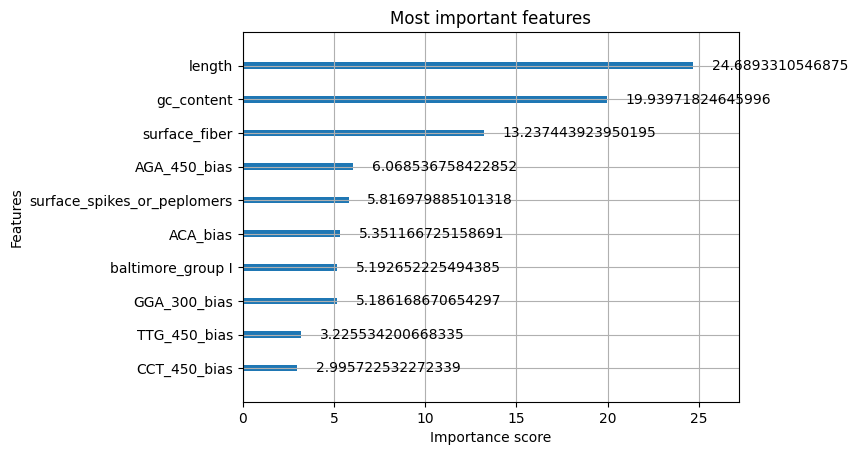

In [ ]:
# most important features of xgb
xgbb.plot_importance(xgb, importance_type='gain', max_num_features=10)
plt.title("Most important features")
plt.show()

In [ ]:
new_h = pd.read_csv("/content/drive/MyDrive/hth.csv")
new = new_h.merge(human_to_human, on="virusID", how="left")
new

,count
human_to_human,
1,966
0,423


# **Visualisation**

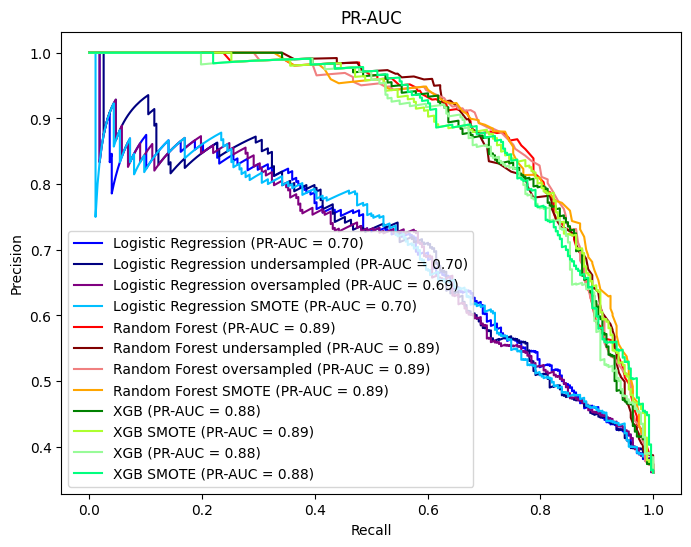

In [ ]:
# PR-AUC Plot viral features
precision1, recall1, _ = precision_recall_curve(y_test_virus, y_prob_virus_1)
precision2, recall2, _ = precision_recall_curve(y_test_virus, y_prob_virus_2)
precision3, recall3, _ = precision_recall_curve(y_test_virus, y_prob_virus_3)
precision4, recall4, _ = precision_recall_curve(y_test_virus, y_prob_virus_4)
precision5, recall5, _ = precision_recall_curve(y_test_virus, y_prob_virus_5)
precision6, recall6, _ = precision_recall_curve(y_test_virus, y_prob_virus_6)
precision7, recall7, _ = precision_recall_curve(y_test_virus, y_prob_virus_7)
precision8, recall8, _ = precision_recall_curve(y_test_virus, y_prob_virus_8)
precision9, recall9, _ = precision_recall_curve(y_test_virus, y_prob_virus_9)
precision10, recall10, _ = precision_recall_curve(y_test_virus, y_prob_virus_10)
precision11, recall11, _ = precision_recall_curve(y_test_virus, y_prob_virus_11)
precision12, recall12, _ = precision_recall_curve(y_test_virus, y_prob_virus_12)

pr_auc1 = auc(recall1, precision1)
pr_auc2 = auc(recall2, precision2)
pr_auc3 = auc(recall3, precision3)
pr_auc4 = auc(recall4, precision4)
pr_auc5 = auc(recall5, precision5)
pr_auc6 = auc(recall6, precision6)
pr_auc7 = auc(recall7, precision7)
pr_auc8 = auc(recall8, precision8)
pr_auc9 = auc(recall9, precision9)
pr_auc10 = auc(recall10, precision10)
pr_auc11 = auc(recall11, precision11)
pr_auc12 = auc(recall12, precision12)

plt.figure(figsize=(8,6))
plt.plot(recall1, precision1, label=f'Logistic Regression (PR-AUC = {pr_auc1:.2f})', color="blue")
plt.plot(recall2, precision2, label=f'Logistic Regression undersampled (PR-AUC = {pr_auc2:.2f})', color="navy")
plt.plot(recall3, precision3, label=f'Logistic Regression oversampled (PR-AUC = {pr_auc3:.2f})', color="purple")
plt.plot(recall4, precision4, label=f'Logistic Regression SMOTE (PR-AUC = {pr_auc4:.2f})', color="deepskyblue")
plt.plot(recall5, precision5, label=f'Random Forest (PR-AUC = {pr_auc5:.2f})', color="red")
plt.plot(recall6, precision6, label=f'Random Forest undersampled (PR-AUC = {pr_auc6:.2f})', color="maroon")
plt.plot(recall7, precision7, label=f'Random Forest oversampled (PR-AUC = {pr_auc7:.2f})', color="lightcoral")
plt.plot(recall8, precision8, label=f'Random Forest SMOTE (PR-AUC = {pr_auc8:.2f})', color="orange")
plt.plot(recall9, precision9, label=f'XGB (PR-AUC = {pr_auc9:.2f})', color="green")
plt.plot(recall10, precision10, label=f'XGB SMOTE (PR-AUC = {pr_auc10:.2f})', color="greenyellow")
plt.plot(recall11, precision11, label=f'XGB (PR-AUC = {pr_auc11:.2f})', color="palegreen")
plt.plot(recall12, precision12, label=f'XGB SMOTE (PR-AUC = {pr_auc12:.2f})', color="springgreen")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR-AUC")
plt.legend()
plt.show()

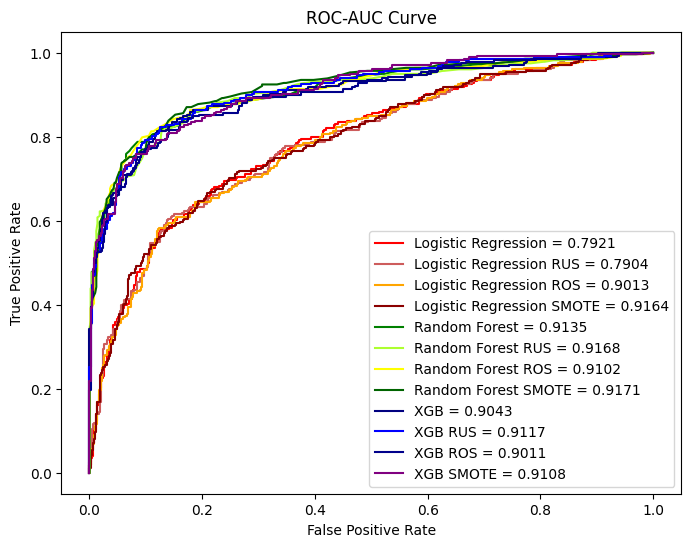

In [ ]:
# ROC-AUC Plot viral features
fpr1, tpr1, _ = roc_curve(y_test_virus, y_prob_virus_1)
fpr2, tpr2, _ = roc_curve(y_test_virus, y_prob_virus_2)
fpr3, tpr3, _ = roc_curve(y_test_virus, y_prob_virus_3)
fpr4, tpr4, _ = roc_curve(y_test_virus, y_prob_virus_4)
fpr5, tpr5, _ = roc_curve(y_test_virus, y_prob_virus_5)
fpr6, tpr6, _ = roc_curve(y_test_virus, y_prob_virus_6)

fpr7, tpr7, _ = roc_curve(y_test_virus, y_prob_virus_7)
fpr8, tpr8, _ = roc_curve(y_test_virus, y_prob_virus_8)
fpr9, tpr9, _ = roc_curve(y_test_virus, y_prob_virus_9)
fpr10, tpr10, _ = roc_curve(y_test_virus, y_prob_virus_10)
fpr11, tpr11, _ = roc_curve(y_test_virus, y_prob_virus_11)
fpr12, tpr12, _ = roc_curve(y_test_virus, y_prob_virus_12)

plt.figure(figsize=(8,6))
plt.plot(fpr1, tpr1, label=f'Logistic Regression = {roc_auc_1:.4f}', color="red")
plt.plot(fpr2, tpr2, label=f'Logistic Regression RUS = {roc_auc_2:.4f}', color="indianred")
plt.plot(fpr3, tpr3, label=f'Logistic Regression ROS = {roc_auc_3:.4f}', color="orange")
plt.plot(fpr4, tpr4, label=f'Logistic Regression SMOTE = {roc_auc_4:.4f}', color="darkred")
plt.plot(fpr5, tpr5, label=f'Random Forest = {roc_auc_5:.4f}', color="green")
plt.plot(fpr6, tpr6, label=f'Random Forest RUS = {roc_auc_6:.4f}', color="greenyellow")

plt.plot(fpr7, tpr7, label=f'Random Forest ROS = {roc_auc_7:.4f}', color="yellow")
plt.plot(fpr8, tpr8, label=f'Random Forest SMOTE = {roc_auc_8:.4f}', color="darkgreen")
plt.plot(fpr9, tpr9, label=f'XGB = {roc_auc_9:.4f}', color="navy")
plt.plot(fpr10, tpr10, label=f'XGB RUS = {roc_auc_10:.4f}', color="blue")
plt.plot(fpr11, tpr11, label=f'XGB ROS = {roc_auc_11:.4f}', color="darkblue")
plt.plot(fpr12, tpr12, label=f'XGB SMOTE = {roc_auc_12:.4f}', color="purple")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve")
plt.legend()
plt.show()

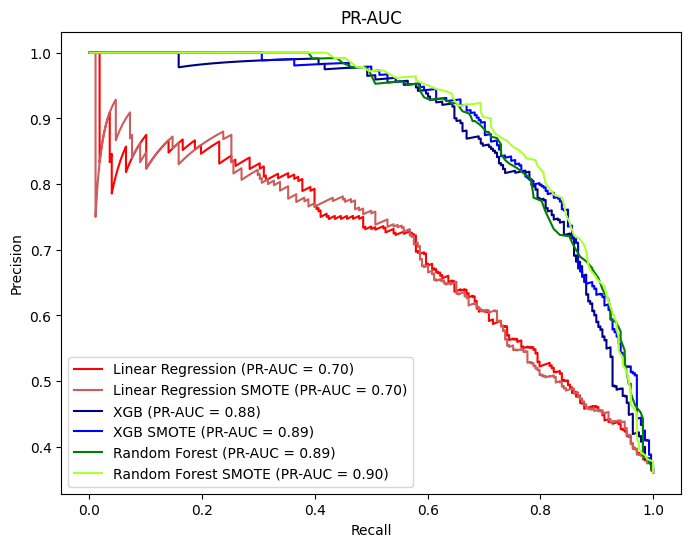

In [ ]:
# PR-AUC Plot infection
precision1, recall1, _ = precision_recall_curve(y_test_both, y_prob_1)
precision2, recall2, _ = precision_recall_curve(y_test_both, y_prob_2)
precision3, recall3, _ = precision_recall_curve(y_test_both, y_prob_3)
precision4, recall4, _ = precision_recall_curve(y_test_both, y_prob_4)
precision5, recall5, _ = precision_recall_curve(y_test_both, y_prob_5)
precision6, recall6, _ = precision_recall_curve(y_test_both, y_prob_6)

pr_auc1 = auc(recall1, precision1)
pr_auc2 = auc(recall2, precision2)
pr_auc3 = auc(recall3, precision3)
pr_auc4 = auc(recall4, precision4)
pr_auc5 = auc(recall5, precision5)
pr_auc6 = auc(recall6, precision6)

plt.figure(figsize=(8,6))
plt.plot(recall1, precision1, label=f'Linear Regression (PR-AUC = {pr_auc1:.2f})', color="red")
plt.plot(recall2, precision2, label=f'Linear Regression SMOTE (PR-AUC = {pr_auc2:.2f})', color="indianred")
plt.plot(recall3, precision3, label=f'XGB (PR-AUC = {pr_auc3:.2f})', color="navy")
plt.plot(recall4, precision4, label=f'XGB SMOTE (PR-AUC = {pr_auc4:.2f})', color="blue")
plt.plot(recall5, precision5, label=f'Random Forest (PR-AUC = {pr_auc5:.2f})', color="green")
plt.plot(recall6, precision6, label=f'Random Forest SMOTE (PR-AUC = {pr_auc6:.2f})', color="greenyellow")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR-AUC")
plt.legend()
plt.show()

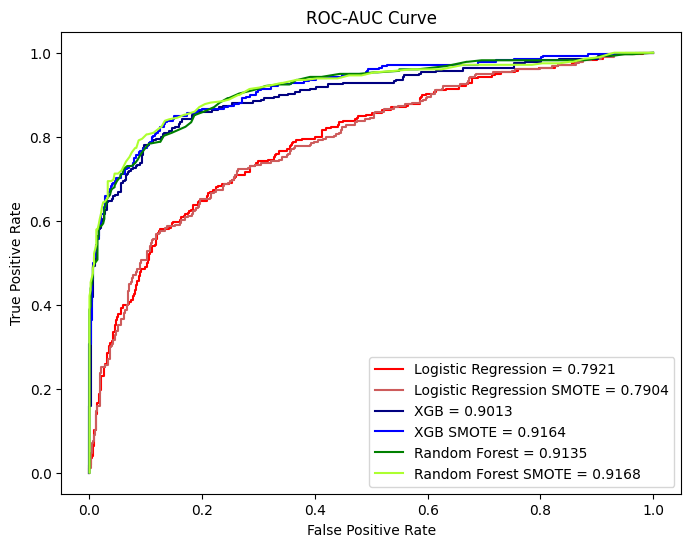

In [ ]:
# ROC-AUC Plot infection
fpr1, tpr1, _ = roc_curve(y_test_both, y_prob_1)
fpr2, tpr2, _ = roc_curve(y_test_both, y_prob_2)
fpr3, tpr3, _ = roc_curve(y_test_both, y_prob_3)
fpr4, tpr4, _ = roc_curve(y_test_both, y_prob_4)
fpr5, tpr5, _ = roc_curve(y_test_both, y_prob_5)
fpr6, tpr6, _ = roc_curve(y_test_both, y_prob_6)

plt.figure(figsize=(8,6))
plt.plot(fpr1, tpr1, label=f'Logistic Regression = {roc_auc_1:.4f}', color="red")
plt.plot(fpr2, tpr2, label=f'Logistic Regression SMOTE = {roc_auc_2:.4f}', color="indianred")
plt.plot(fpr3, tpr3, label=f'XGB = {roc_auc_3:.4f}', color="navy")
plt.plot(fpr4, tpr4, label=f'XGB SMOTE = {roc_auc_4:.4f}', color="blue")
plt.plot(fpr5, tpr5, label=f'Random Forest = {roc_auc_5:.4f}', color="green")
plt.plot(fpr6, tpr6, label=f'Random Forest SMOTE = {roc_auc_6:.4f}', color="greenyellow")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve")
plt.legend()
plt.show()

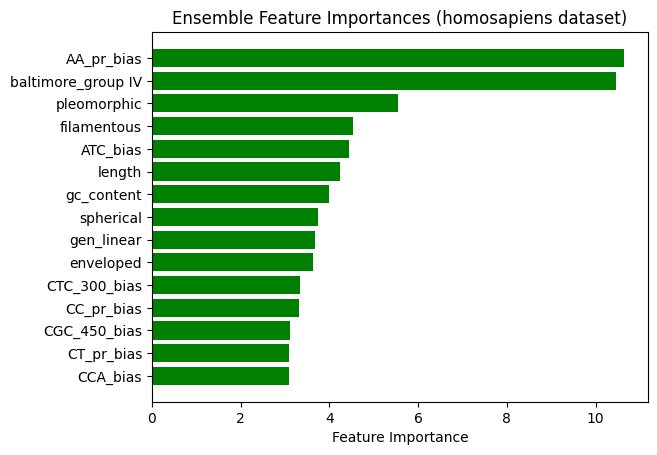

In [ ]:
# feature importance from the homosapiens dataset (ensemble)
importances_rf = rf_virus.feature_importances_
importances_rf_smote = rf_virus_sm.feature_importances_
importances_rf_d = rf_virus_d.feature_importances_
importances_rf_o = rf_virus_o.feature_importances_

importances_xgb = xgb_virus.get_booster().get_score(importance_type='gain')
importances_xgb_smote = xgb_virus_sm.get_booster().get_score(importance_type='gain')
importances_xgb_d = xgb_virus_d.get_booster().get_score(importance_type='gain')
importances_xgb_o = xgb_virus_o.get_booster().get_score(importance_type='gain')

importances_xgb_list = [importances_xgb.get(f, 0) for f in X_virus.columns]
importances_xgb_list_smote = [importances_xgb_smote.get(f, 0) for f in X_virus.columns]
importances_xgb_list_d = [importances_xgb_d.get(f, 0) for f in X_virus.columns]
importances_xgb_list_o = [importances_xgb_o.get(f, 0) for f in X_virus.columns]


combined_importances = (importances_rf + importances_rf_smote + importances_rf_d + importances_rf_o + importances_xgb_list +
                        importances_xgb_list_smote + importances_xgb_list_d + importances_xgb_list_o) / 8
indices_combined = combined_importances.argsort()

plt.title("Ensemble Feature Importances (homosapiens dataset)")
plt.barh(range(15), combined_importances[indices_combined[-15:]], align="center", color="green")
plt.yticks(range(15), [X_virus.columns[i] for i in indices_combined[-15:]])
plt.xlabel("Feature Importance")
plt.show()

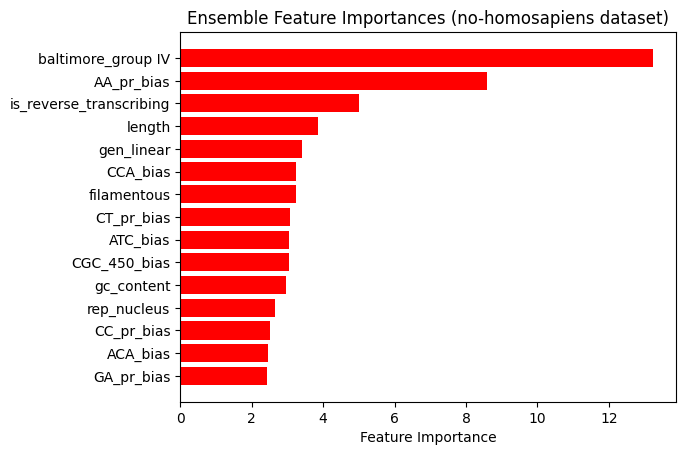

In [ ]:
# feature importance from the no-homosapiens dataset (ensemble)
importances_rf = rf_both.feature_importances_
importances_rf_smote = rf_both_smote.feature_importances_
importances_xgb = xgb_both.get_booster().get_score(importance_type='gain')
importances_xgb_smote = xgb_both_smote.get_booster().get_score(importance_type='gain')

importances_xgb_list = [importances_xgb.get(f, 0) for f in X_both.columns]
importances_xgb_list_smote = [importances_xgb_smote.get(f, 0) for f in X_both.columns]

combined_importances = (importances_rf + importances_rf_smote + importances_xgb_list + importances_xgb_list_smote) / 4
indices_combined = combined_importances.argsort()

plt.title("Ensemble Feature Importances (no-homosapiens dataset)")
plt.barh(range(15), combined_importances[indices_combined[-15:]], align="center", color="red")
plt.yticks(range(15), [X_both.columns[i] for i in indices_combined[-15:]])
plt.xlabel("Feature Importance")
plt.show()

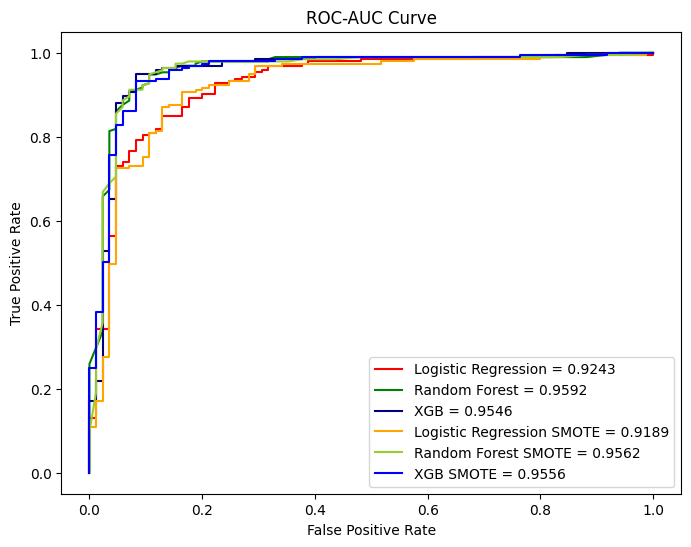

In [ ]:
# roc auc transmission
fpr_tr, tpr_tr, _ = roc_curve(y_test_transmit, y_prob_transmit_1)
fpr_tra, tpr_tra, _ = roc_curve(y_test_transmit, y_prob_transmit_5)
fpr_tran, tpr_tran, _ = roc_curve(y_test_transmit, y_prob_transmit_9)

fpr_l, tpr_l, _ = roc_curve(y_test_transmit, y_prob_transmit_sm)
fpr_r, tpr_r, _ = roc_curve(y_test_transmit, y_prob_transmit_smr)
fpr_x, tpr_x, _ = roc_curve(y_test_transmit, y_prob_transmit_smx)

plt.figure(figsize=(8,6))
plt.plot(fpr_tr, tpr_tr, label=f'Logistic Regression = {roc_auc_tr:.4f}', color="red")
plt.plot(fpr_tra, tpr_tra, label=f'Random Forest = {roc_auc_tra:.4f}', color="green")
plt.plot(fpr_tran, tpr_tran, label=f'XGB = {roc_auc_tran:.4f}', color="navy")

plt.plot(fpr_l, tpr_l, label=f'Logistic Regression SMOTE = {roc_auc_tr_sm:.4f}', color="orange")
plt.plot(fpr_r, tpr_r, label=f'Random Forest SMOTE = {roc_auc_tr_smr:.4f}', color="yellowgreen")
plt.plot(fpr_x, tpr_x, label=f'XGB SMOTE = {roc_auc_tr_smx:.4f}', color="blue")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve")
plt.legend()
plt.show()

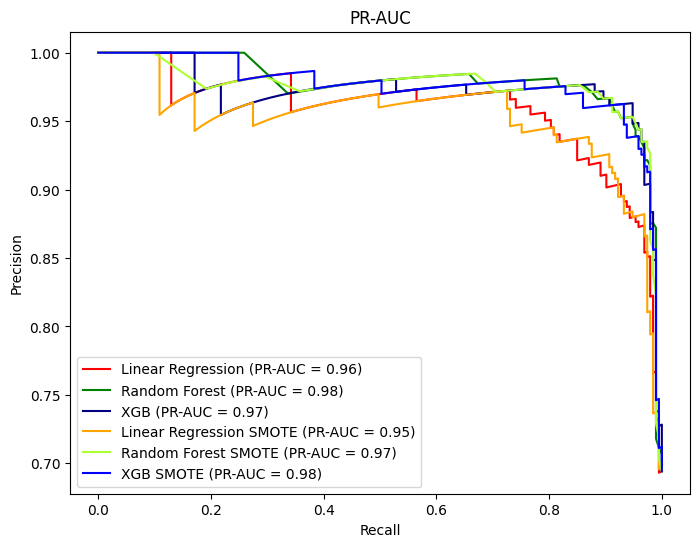

In [ ]:
# pr-auc transmission
precision_tr, recall_tr, _ = precision_recall_curve(y_test_transmit, y_prob_transmit_1)
precision_tra, recall_tra, _ = precision_recall_curve(y_test_transmit, y_prob_transmit_5)
precision_tran, recall_tran, _ = precision_recall_curve(y_test_transmit, y_prob_transmit_9)

precision_l, recall_l, _ = precision_recall_curve(y_test_transmit, y_prob_transmit_sm)
precision_r, recall_r, _ = precision_recall_curve(y_test_transmit, y_prob_transmit_smr)
precision_x, recall_x, _ = precision_recall_curve(y_test_transmit, y_prob_transmit_smx)

pr_auc_tr = auc(recall_tr, precision_tr)
pr_auc_tra = auc(recall_tra, precision_tra)
pr_auc_tran = auc(recall_tran, precision_tran)

pr_auc_l = auc(recall_l, precision_l)
pr_auc_r = auc(recall_r, precision_r)
pr_auc_x = auc(recall_x, precision_x)


plt.figure(figsize=(8,6))
plt.plot(recall_tr, precision_tr, label=f'Linear Regression (PR-AUC = {pr_auc_tr:.2f})', color="red")
plt.plot(recall_tra, precision_tra, label=f'Random Forest (PR-AUC = {pr_auc_tra:.2f})', color="green")
plt.plot(recall_tran, precision_tran, label=f'XGB (PR-AUC = {pr_auc_tran:.2f})', color="navy")

plt.plot(recall_l, precision_l, label=f'Linear Regression SMOTE (PR-AUC = {pr_auc_l:.2f})', color="orange")
plt.plot(recall_r, precision_r, label=f'Random Forest SMOTE (PR-AUC = {pr_auc_r:.2f})', color="greenyellow")
plt.plot(recall_x, precision_x, label=f'XGB SMOTE (PR-AUC = {pr_auc_x:.2f})', color="blue")


plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR-AUC")
plt.legend()
plt.show()

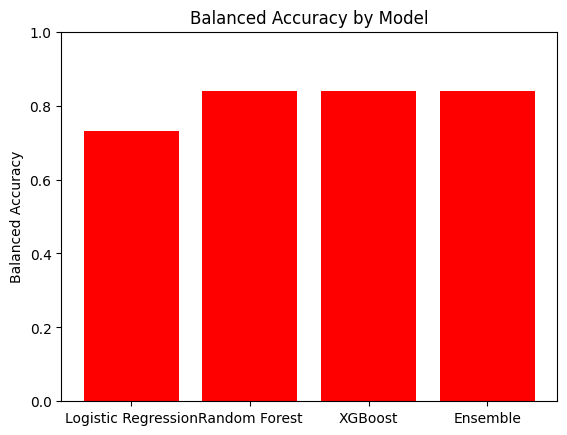

In [ ]:
# balanced accuracy transmission
models = ['Logistic Regression', 'Random Forest', 'XGBoost', "Ensemble"]
balanced_accuracies = [0.73, 0.84, 0.84, 0.84]

plt.bar(models, balanced_accuracies, color='red')
plt.ylabel("Balanced Accuracy")
plt.title("Balanced Accuracy by Model")
plt.ylim(0, 1)
plt.show()

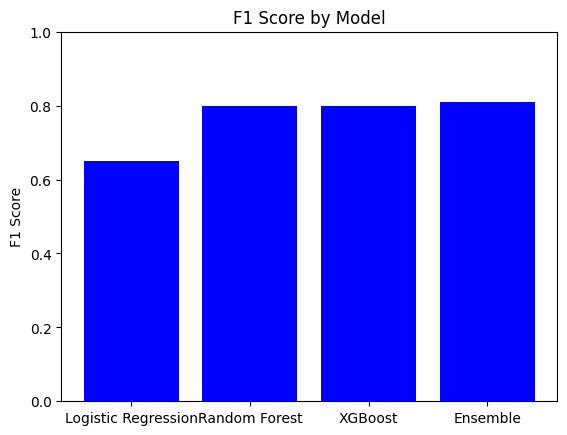

In [ ]:
# f1 transmission
models = ['Logistic Regression', 'Random Forest', 'XGBoost', "Ensemble"]
f1_scores = [0.65, 0.80, 0.80, 0.81]
plt.bar(models, f1_scores, color='blue')
plt.ylabel("F1 Score")
plt.title("F1 Score by Model")
plt.ylim(0, 1)
plt.show()